In [10]:
import warnings
warnings.filterwarnings('ignore')

Step 1 - Import python libraries

In [11]:
from IPython import get_ipython
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

Step 2 - Load and read your data file
- pyTCR accepts a single `.csv` file that should contain all the samples.
  - The following cell attempts to detect whether you are running the notebook in a Google Colab cloud environment or in a local environment, and then loads the data at the specified path.
- The `filePath` variable in the following code cell should be changed to the location of your file. The following options are supported:
  1. A `filePath` from Google Drive (to run on a cloud environment)
  2. A `filePath` from your local computer (to run on a local environment, other cloud environments should work as expected)
- Adjust the `optional_fields` according to your data

In [4]:
# Specify the path to your data in Google Drive or locally
filePath = "/scratch1/pjaiswal/ipynb_notebooks/master_files/TRUST4_inhouse_all.csv" # or "/content/drive/MyDrive/combined_data.csv"
directory_path =  "/scratch1/pjaiswal/figures/"
df_samples = pd.read_csv(filePath, low_memory=False, engine="c")

df_samples.head()

sample      freq  #count           cdr3aa  \
0  HD_23_S7_L001_original_TRUST4  0.055397   13245     CASSLGLNEQFF   
1  HD_23_S7_L001_original_TRUST4  0.017364    9511      CAIQGAQKLVF   
2  HD_23_S7_L001_original_TRUST4  0.015424    8448     CATGAGNTPLVF   
3  HD_23_S7_L001_original_TRUST4  0.014476    7929   CAVTLNTGGFKTIF   
4  HD_23_S7_L001_original_TRUST4  0.031126    7442  CASSQDGGFHNEQFF   

                                          cdr3nt            v         d  \
0           TGTGCCAGCAGTTTAGGGCTCAATGAGCAGTTCTTC    TRBV28*01         .   
1              TGTGCAATCCAGGGAGCCCAGAAGCTGGTATTT    TRAV27*01         .   
2           TGTGCTACGGGGGCAGGAAACACACCTCTTGTCTTT    TRAV17*01         .   
3     TGTGCCGTGACCTTGAATACTGGAGGCTTCAAAACTATCTTT  TRAV12-2*03         .   
4  TGCGCCAGCAGCCAAGATGGGGGGTTTCACAATGAGCAGTTCTTC   TRBV4-1*01  TRBD2*01   

            j             Type  
0  TRBJ2-1*01  Original_TRUST4  
1   TRAJ54*01  Original_TRUST4  
2   TRAJ29*01  Original_TRUST4  
3    TRAJ9*01  Original_TRUST4  
4  TRBJ2-1*01  Original_TRUST4

Prepare two dataframes for merging and analyzing the overlapping

In [5]:
# If there are more than one V or J gene, leave only the first one
df_samples['v'].str.replace("(,).*", "", regex=True)
df_samples['j'].str.replace("(,).*", "", regex=True)

df_compare = pd.merge(df_samples, df_samples, on=['cdr3nt', 'cdr3aa', 'v', 'd', 'j'], suffixes=['_1', '_2'])

df_compare = df_compare[df_compare['sample_1'] != df_compare['sample_2']]
df_compare['#count_1'] = pd.to_numeric(df_compare['#count_1'], errors='coerce')
df_compare['#count_2'] = pd.to_numeric(df_compare['#count_2'], errors='coerce')



In [6]:
df_compare['#count_1**2'] = df_compare['#count_1'] * df_compare['#count_1']
df_compare['#count_2**2'] = df_compare['#count_2'] * df_compare['#count_2']
df_compare['#count_1*2'] = df_compare['#count_1'] * df_compare['#count_2']

# Prepare data for future analysis
sample_names = df_samples["sample"].drop_duplicates()
sample_names_size = sample_names.size
sample_names.index = np.arange(0, sample_names_size)

samples = {}

for sample in sample_names:
    filtered_samples = df_samples.loc[(df_samples['sample'] == sample)]
    samples[sample] = filtered_samples

df_overlaps = {}

for i in range(0, sample_names_size):
    sample1 = sample_names[i]

    df_compare1 = (df_compare['sample_1'] == sample1)

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]

        df_compare2 = (df_compare['sample_2'] == sample2)

        df_rows = df_compare.loc[df_compare1 & df_compare2]
        df_overlaps[f'{sample1}:{sample2}'] = df_rows

Overlap analysis 1.1 - Jaccard index (result table)

In [7]:
# Create an empty dataframe for storing results
columns = ['sample_1', 'sample_2', 'jaccard_index']
df_jaccard_index = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        jaccard_overlap = df_overlaps[f'{sample1}:{sample2}'].shape[0]

        # Calculate Jaccard Index
        jaccard = jaccard_overlap / \
            (df_sample1.shape[0] + df_sample2.shape[0] - jaccard_overlap)

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'jaccard_index': jaccard})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'jaccard_index': jaccard})

    df_data = pd.DataFrame(data)
    df_jaccard_index = pd.concat([df_jaccard_index, df_data], copy=False, ignore_index=True)

Overlap analysis 1.2 - Jaccard index (heatmap)

In [ ]:
df_jaccard_inde

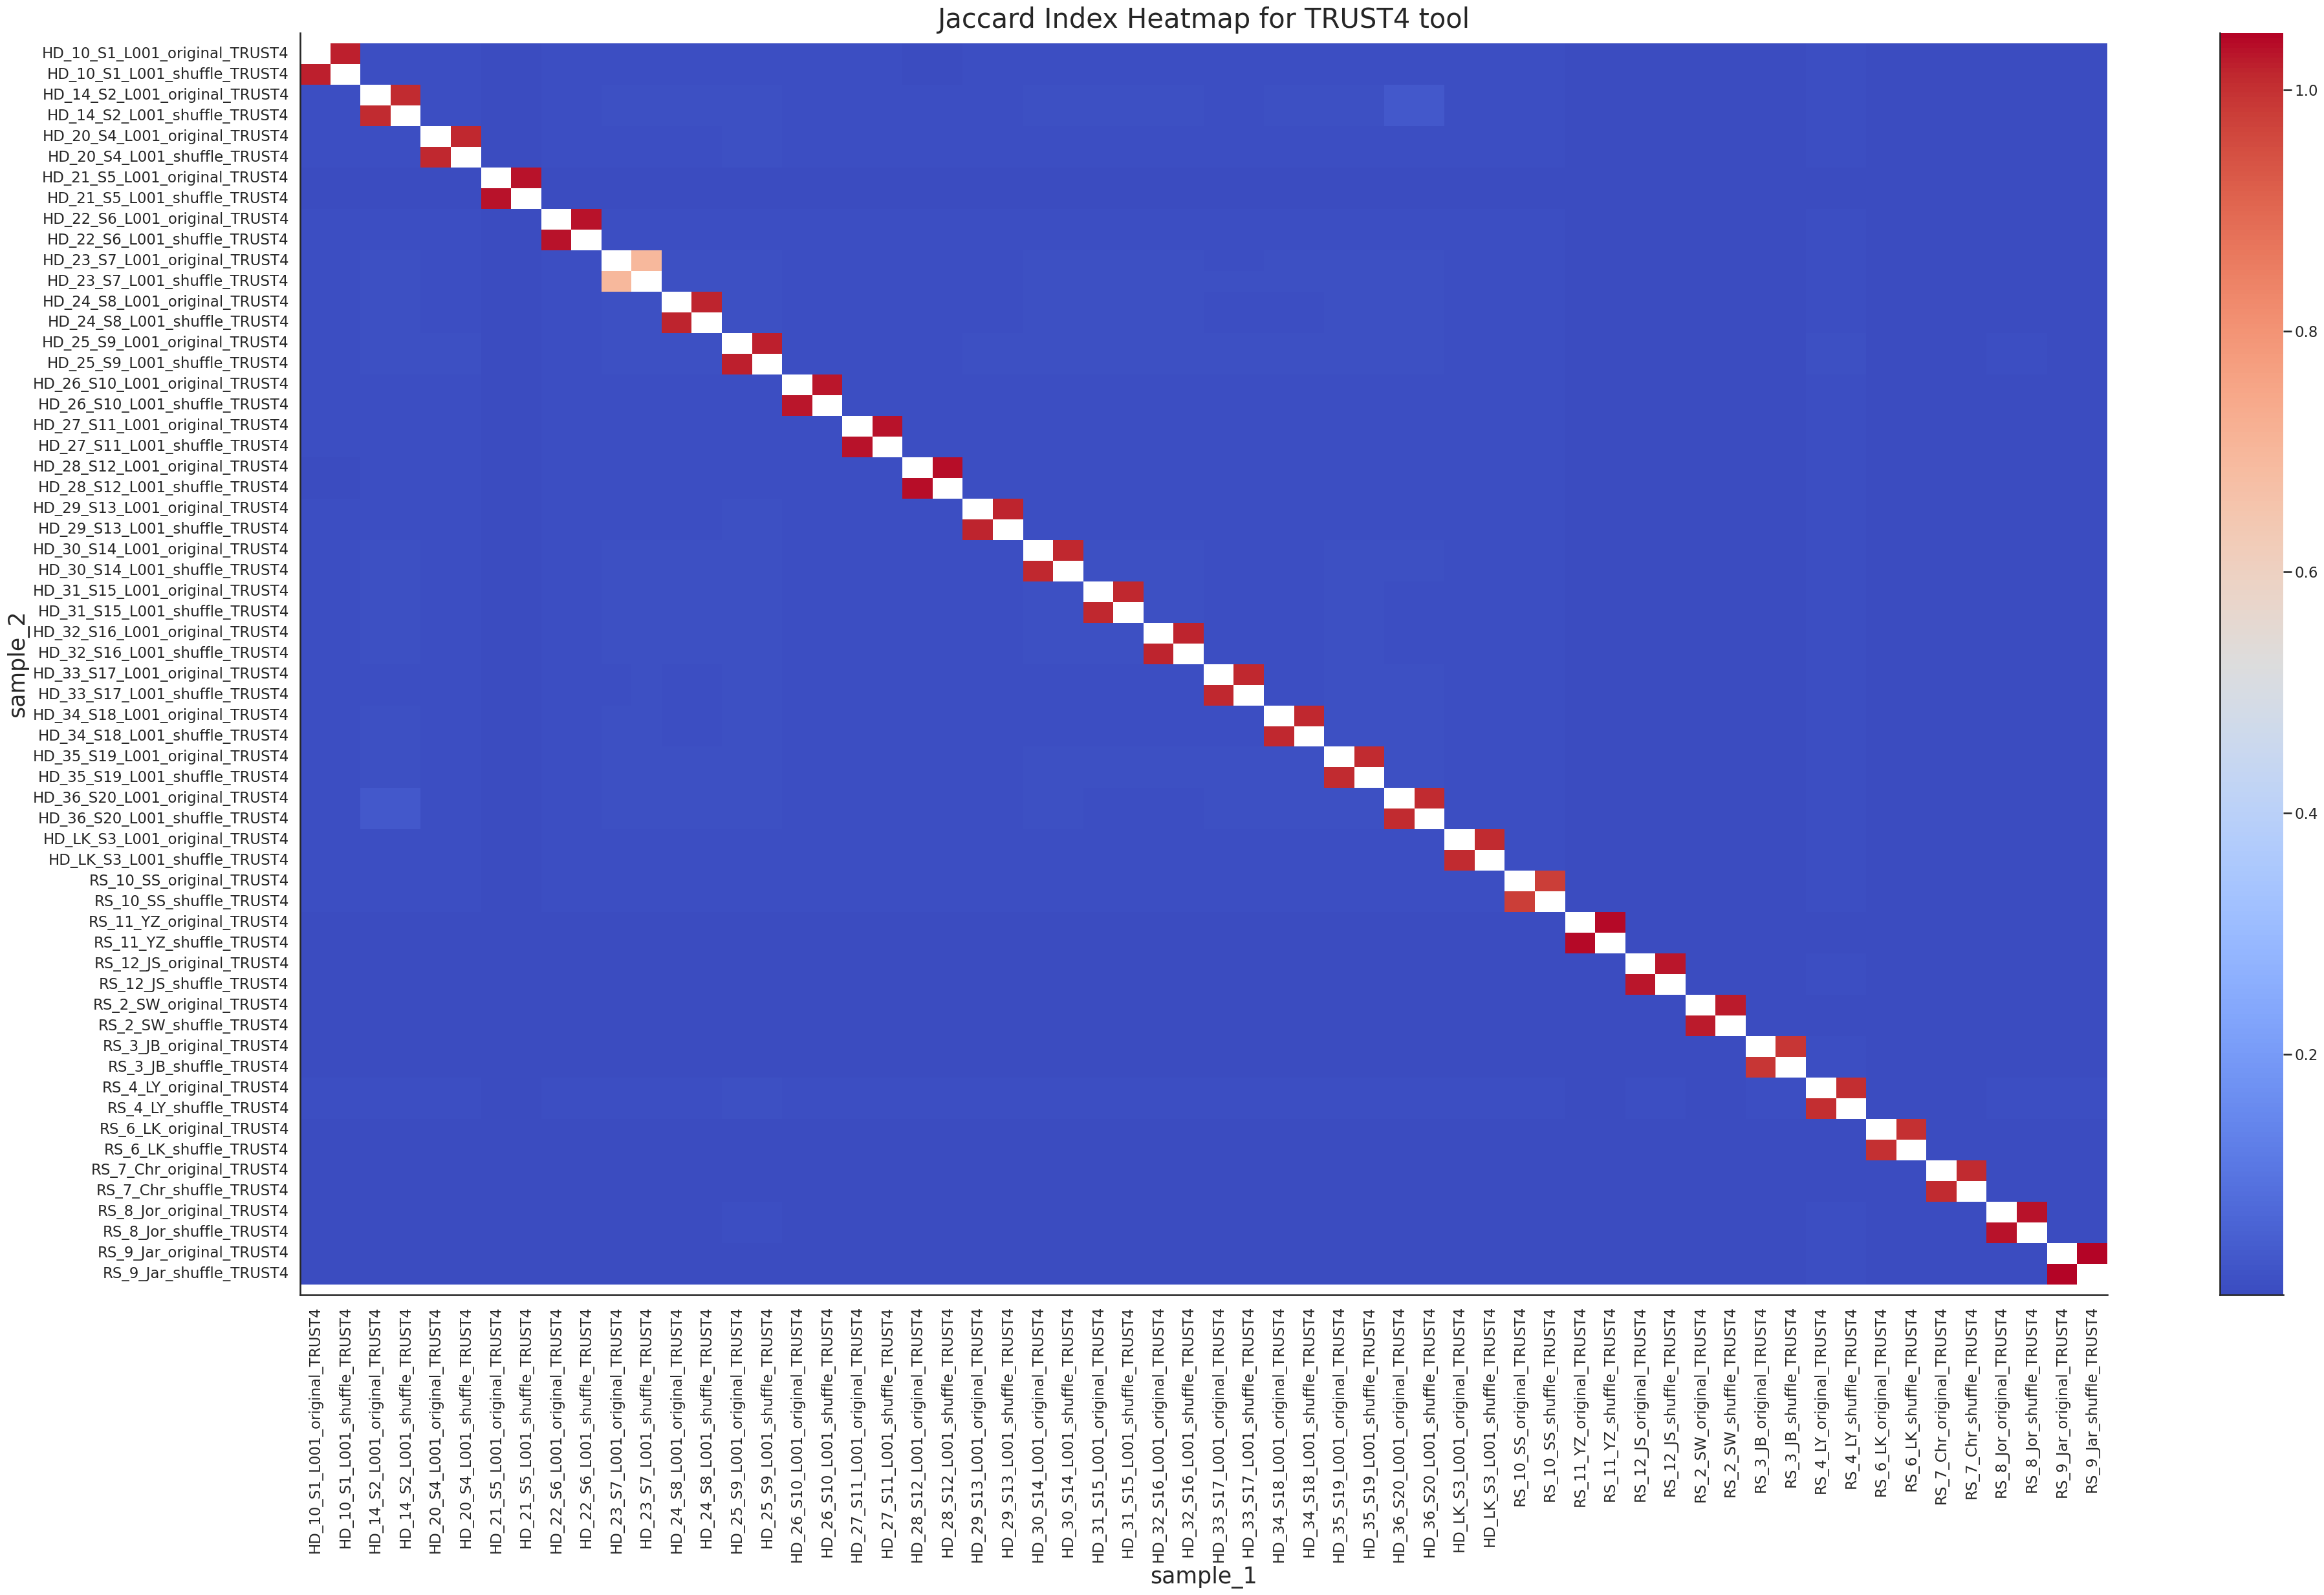

In [8]:
# Set aesthetics
plt.style.use(['ggplot', 'seaborn-v0_8-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# Generate axes
df_jaccard_index['jaccard_index'] = df_jaccard_index['jaccard_index'].astype(float)

result = df_jaccard_index.pivot(index='sample_2', columns='sample_1', values='jaccard_index')

ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=25)
ax.set_ylabel('sample_2', fontsize=25)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Jaccard Index Heatmap for TRUST4 tool', fontsize=30)
sns.despine()
plt.tight_layout()
plt.savefig("/scratch1/pjaiswal/figures/jaccard_index_heatmap_TRUST4_inhouse.png", bbox_inches="tight")
plt.show()

Overlap analysis 3.1 - Morisita-Horn index (result table)

In [9]:
# Create an empty dataframe for storing results
columns = ['sample_1', 'sample_2', 'morisita_horn_index']
df_morisita_horm_index = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        sum_sample_1_count = df_sample1["#count"].sum()
        sum_sample_2_count = df_sample2["#count"].sum()

        sample_overlap = df_overlaps[f'{sample1}:{sample2}']
        # Convert overlap counts to numeric
        sample_overlap["#count_1**2"] = pd.to_numeric(sample_overlap["#count_1**2"], errors='coerce')
        sample_overlap["#count_2**2"] = pd.to_numeric(sample_overlap["#count_2**2"], errors='coerce')
        sample_overlap["#count_1*2"] = pd.to_numeric(sample_overlap["#count_1*2"], errors='coerce')


        sum_sample_1 = sample_overlap["#count_1**2"].sum()
        sum_sample_2 = sample_overlap["#count_2**2"].sum()

        sum_count_product = sample_overlap["#count_1*2"].sum()

        # Calculate Morisita-Horn index
        step1 = (sum_sample_1 / ((sum_sample_1_count)**2)) + \
            (sum_sample_2 / ((sum_sample_2_count)**2))
        step2 = step1 * sum_sample_1_count * sum_sample_2_count
        step3 = 2 * sum_count_product
        morisita_horn_index = step3 / step2

        # Store the results
        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'morisita_horn_index': morisita_horn_index})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'morisita_horn_index': morisita_horn_index})

    df_data = pd.DataFrame(data)
    df_morisita_horm_index = pd.concat(
        [df_morisita_horm_index, df_data], copy=False, ignore_index=True)

Overlap analysis 3.2 - Morisita-Horn index (heatmap)

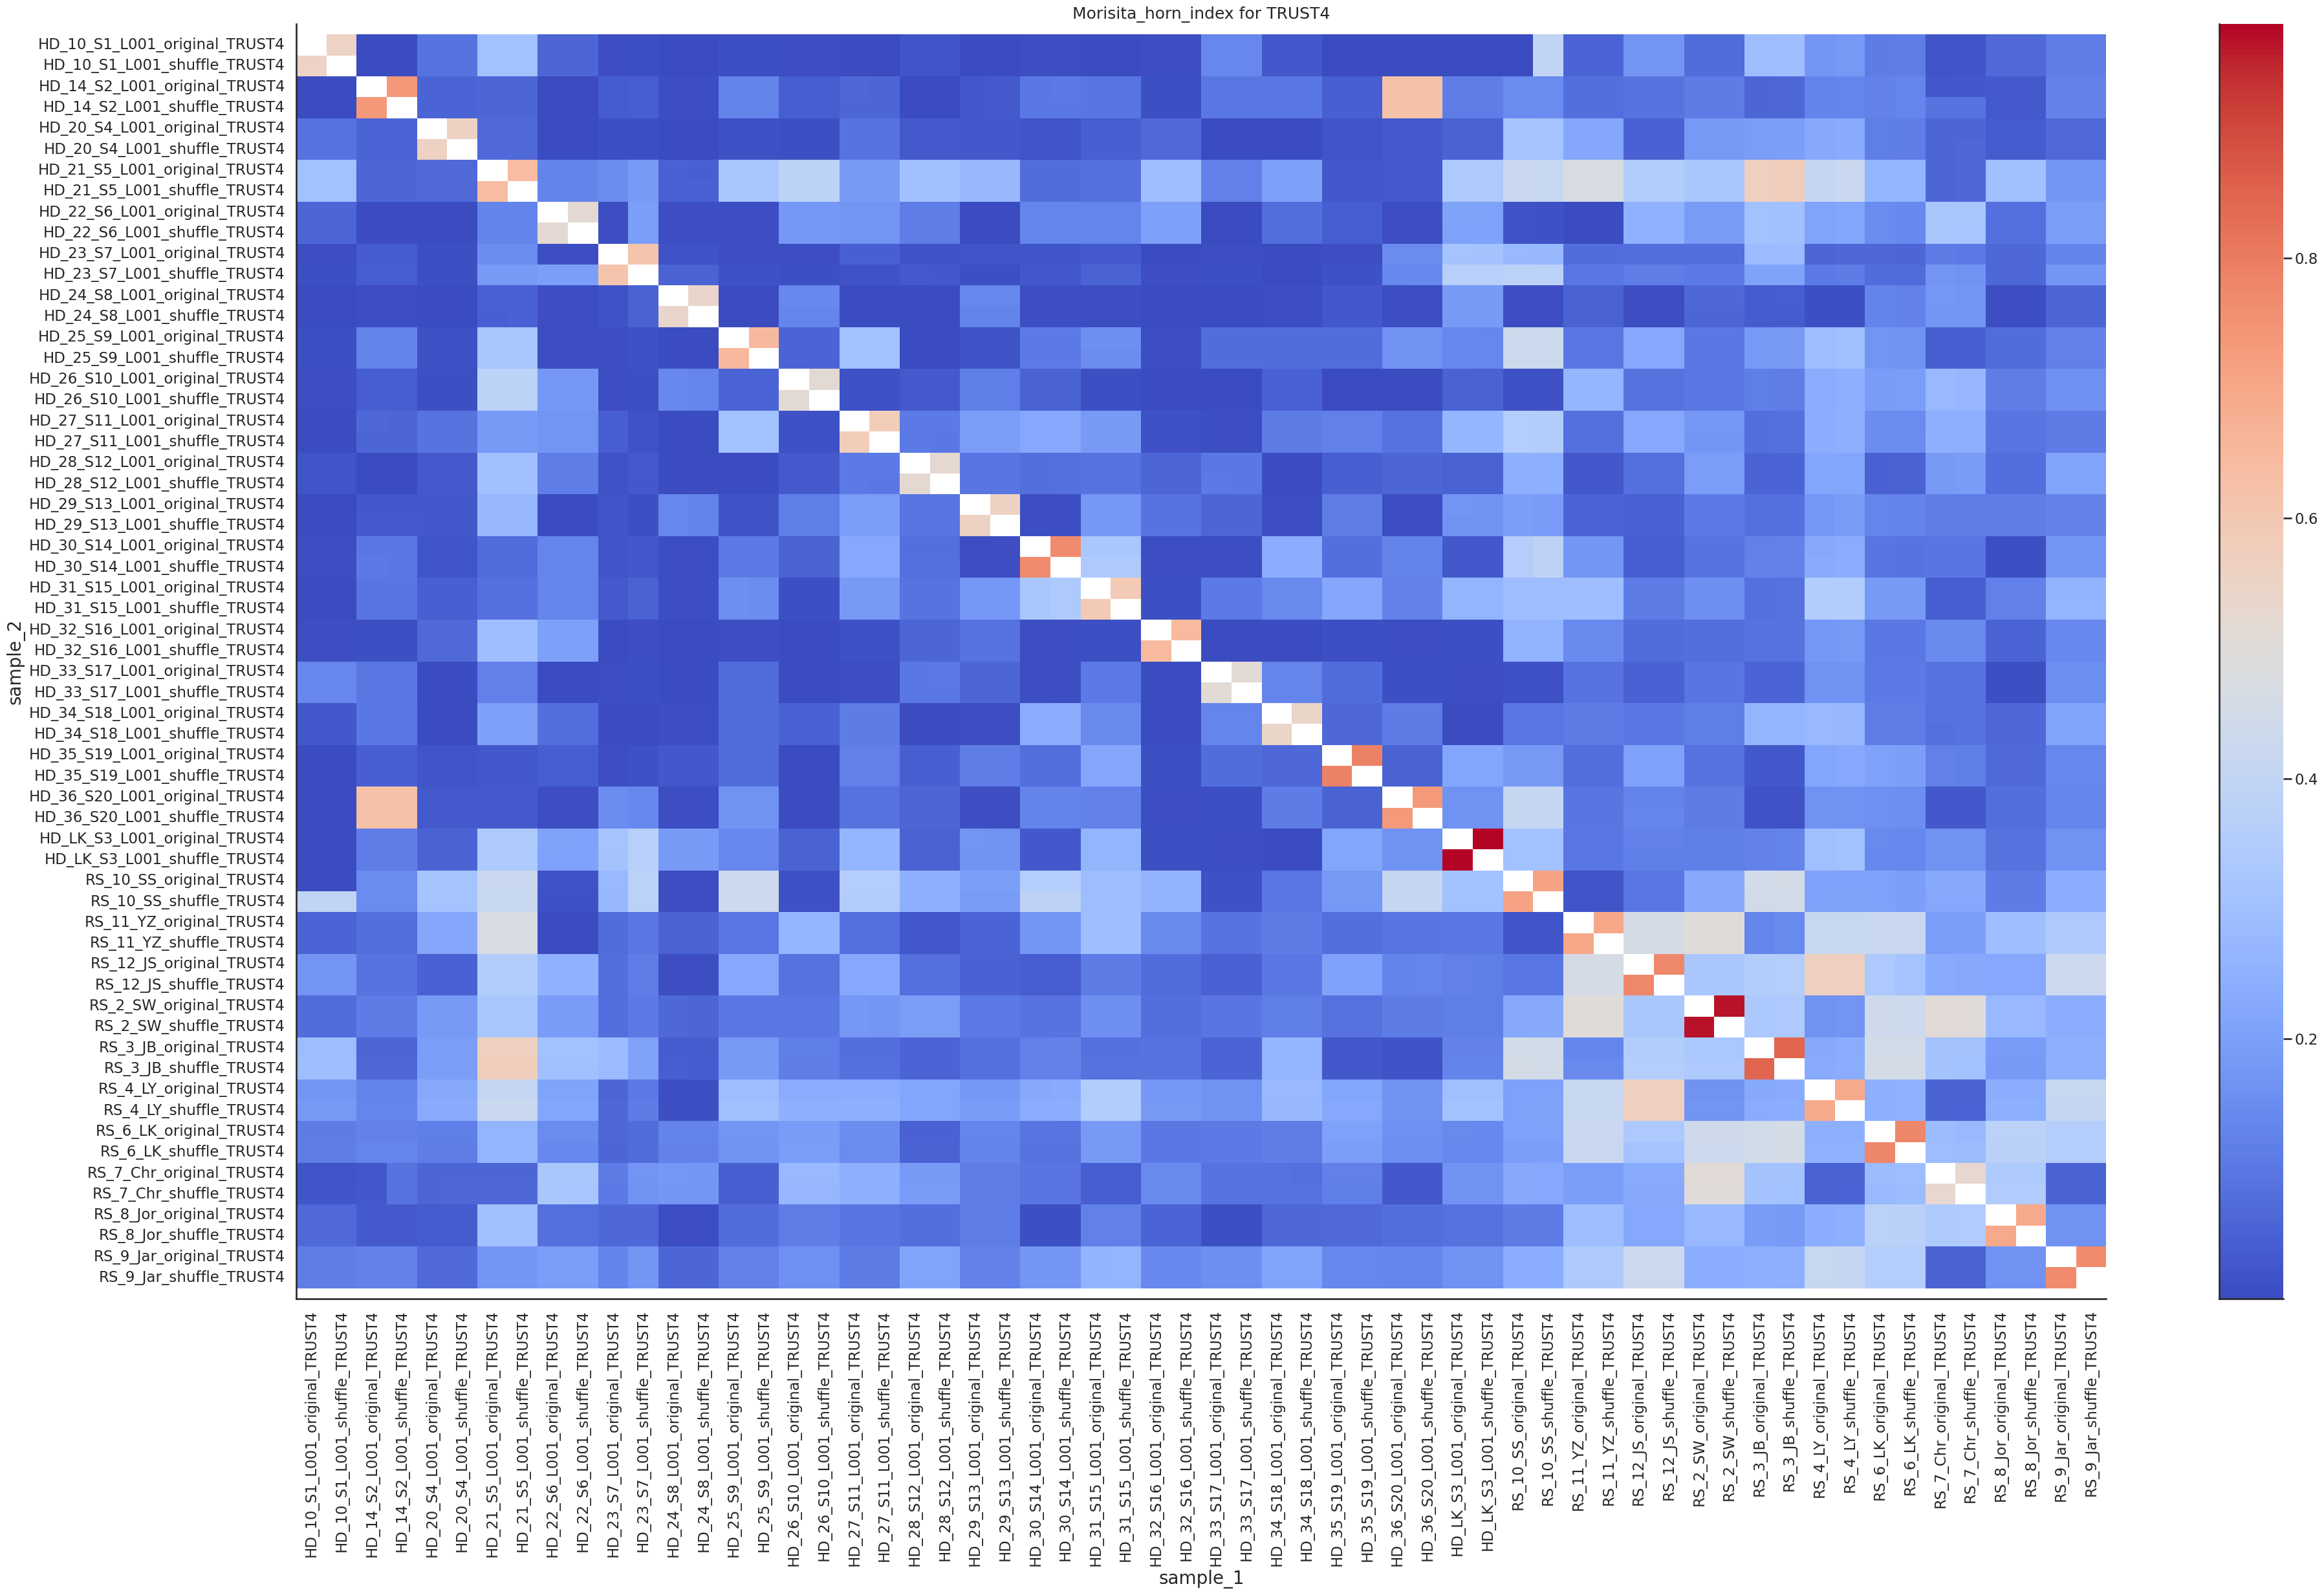

In [12]:
# Set aesthetics
plt.style.use(['ggplot', 'seaborn-v0_8-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# Generate axes
df_morisita_horm_index['morisita_horn_index'] = df_morisita_horm_index['morisita_horn_index'].astype(float)

result = df_morisita_horm_index.pivot(index='sample_2', columns='sample_1', values='morisita_horn_index')

ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=20)
ax.set_ylabel('sample_2', fontsize=20)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('Morisita_horn_index for TRUST4')
plt.tight_layout()
plt.savefig("/scratch1/pjaiswal/figures/Morisita_Horn_TRUST4_inhouse.png", bbox_inches="tight")
sns.despine()
plt.show()

Overlap analysis 5.1 - Cosine similarity (result table)

In [13]:
from scipy.spatial.distance import cosine

columns = ['sample_1', 'sample_2', 'cosine_similarity']
df_cosine_similarity = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        cos_vec = (1 - cosine(df_overlap["freq_1"], df_overlap["freq_2"]))

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'cosine_similarity': cos_vec})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'cosine_similarity': cos_vec})

    df_data = pd.DataFrame(data)
    df_cosine_similarity = pd.concat([df_cosine_similarity, df_data], copy=False, ignore_index=True)

Overlap analysis 5.2 - Cosine similarity (heatmap)

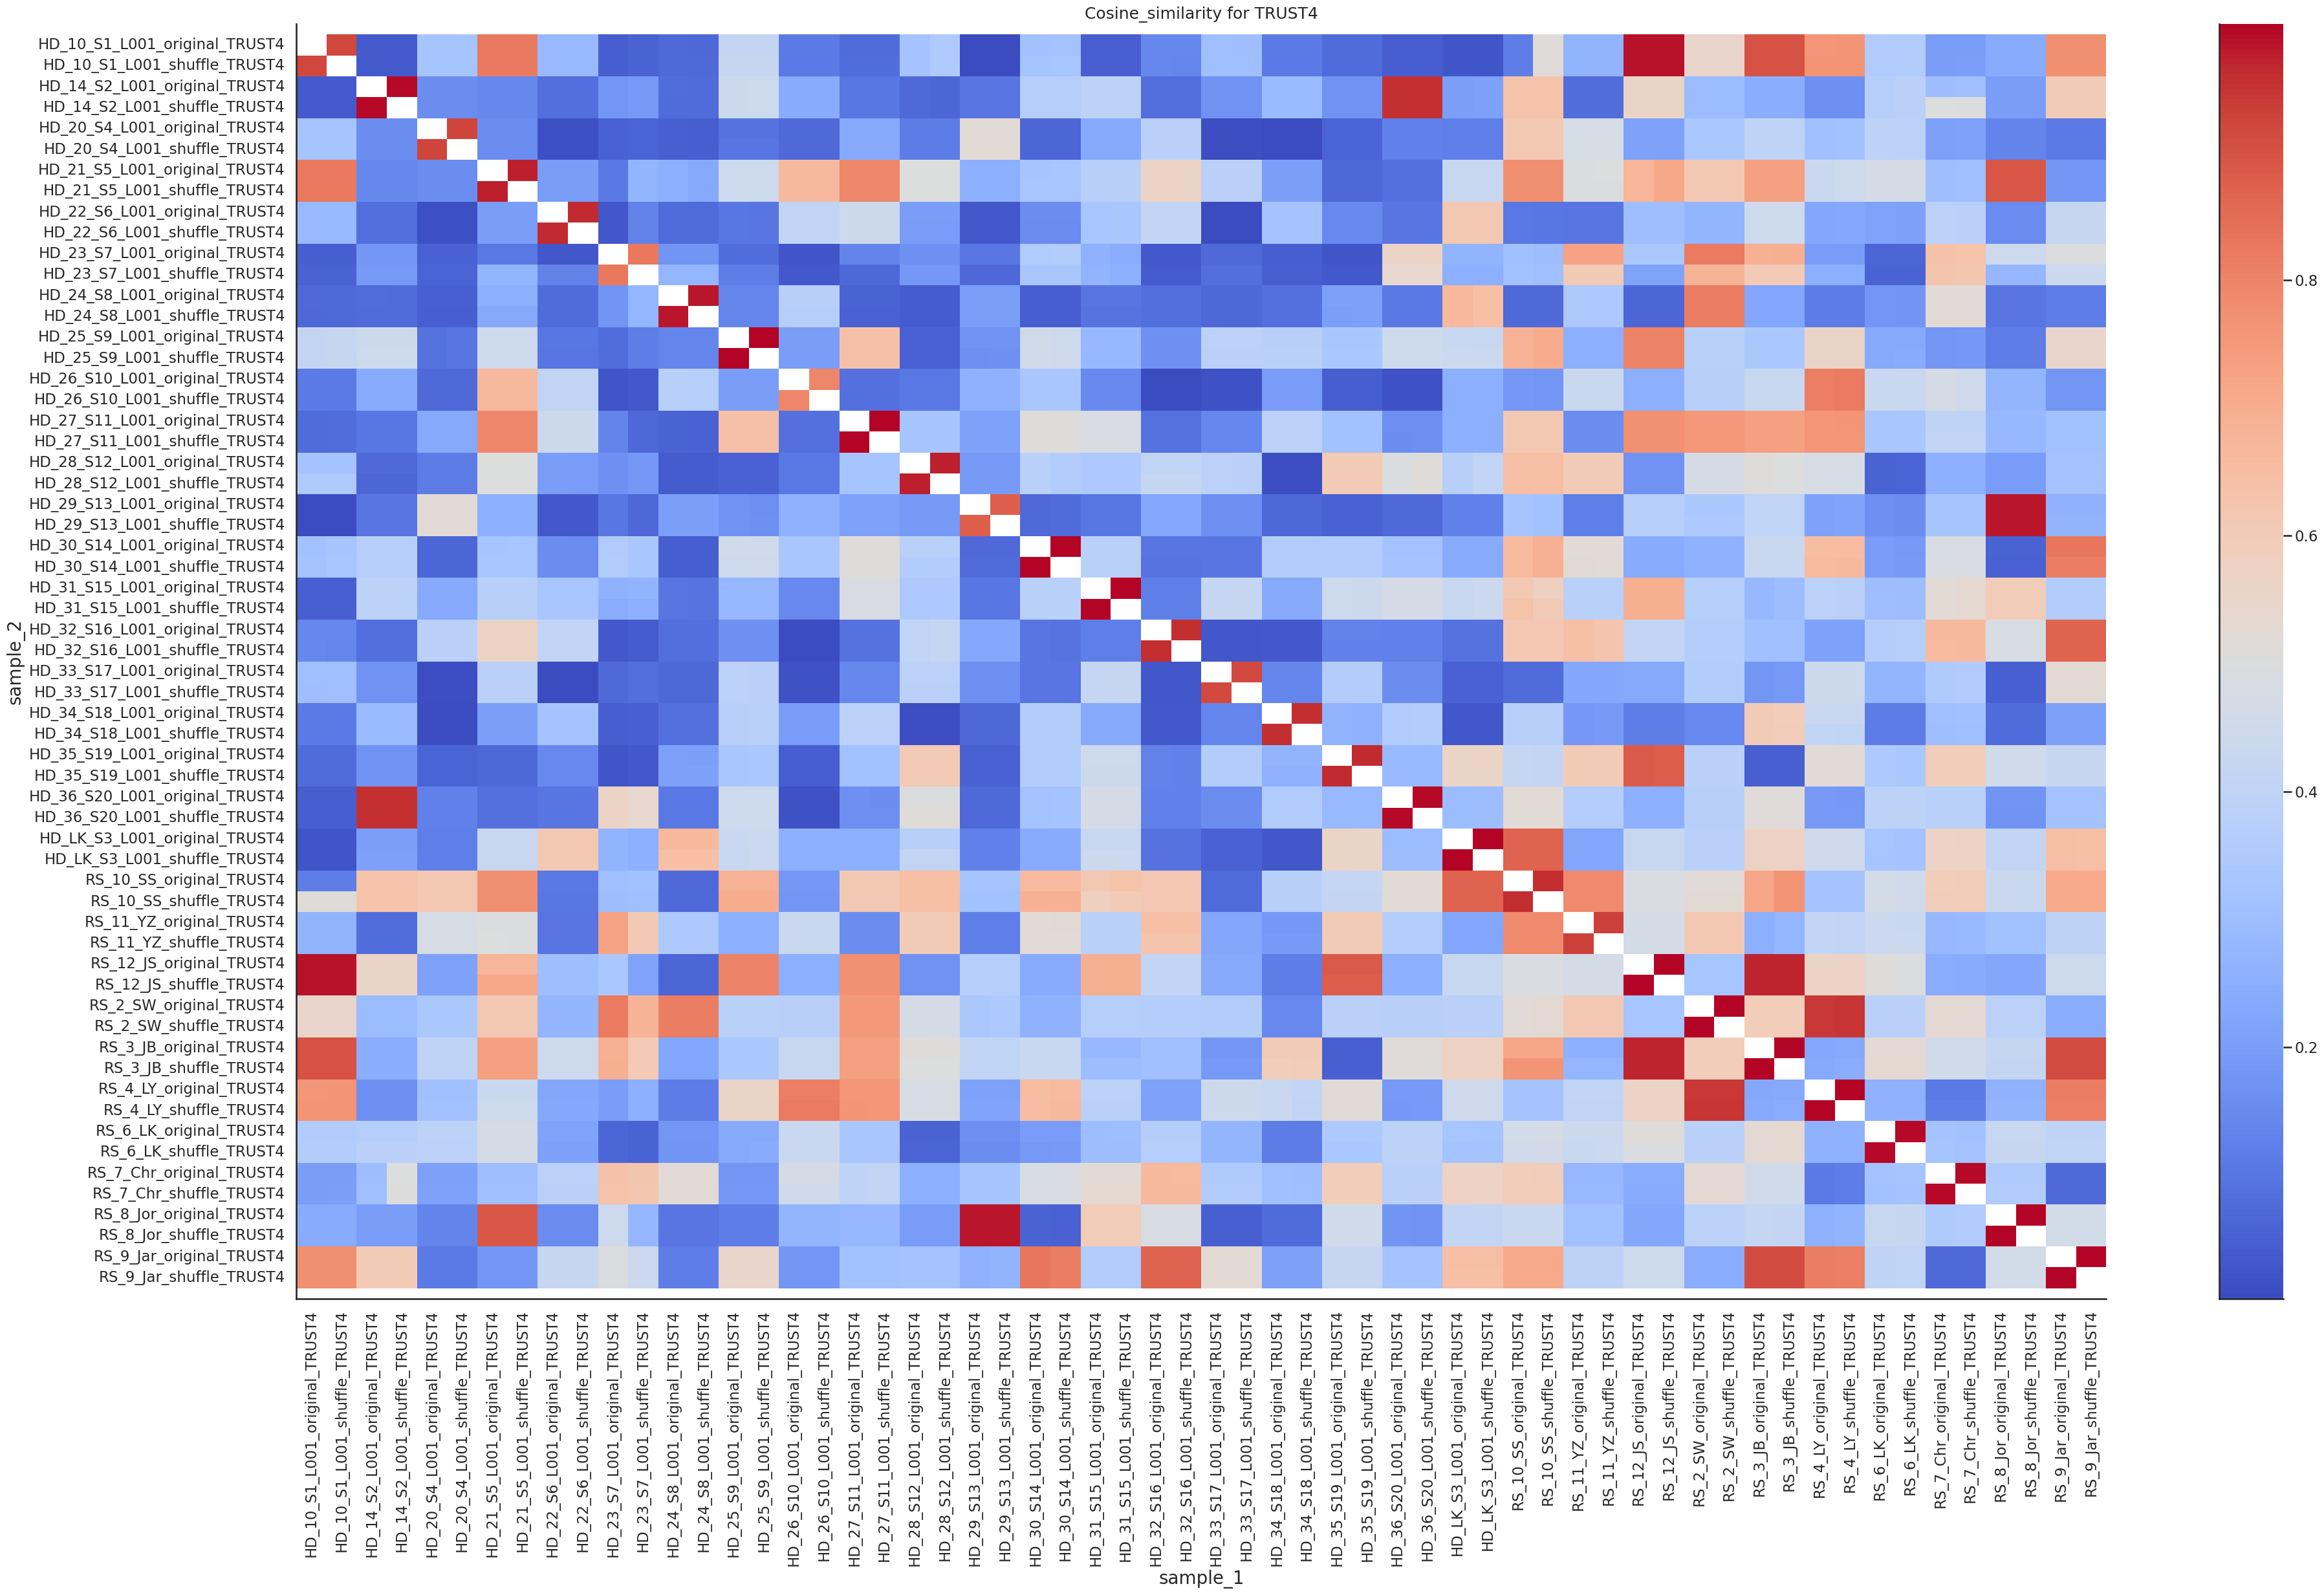

In [14]:
# Set aesthetics
plt.style.use(['ggplot', 'seaborn-v0_8-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# Generate axes
df_cosine_similarity['cosine_similarity'] = df_cosine_similarity['cosine_similarity'].astype(float)

result = df_cosine_similarity.pivot(index='sample_2', columns='sample_1', values='cosine_similarity')

ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=20)
ax.set_ylabel('sample_2', fontsize=20)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('Cosine_similarity for TRUST4')
plt.tight_layout()
plt.savefig("/scratch1/pjaiswal/ipynb_notebooks/Figures/Cosine_similarity_TRUST4.pdf")
sns.despine()
plt.show()

Overlap analysis 6.1.1 - Pearson correlation based on clonotype counts (result table)

In [15]:
columns = ['sample_1', 'sample_2', 'pearson_correlation']
df_pearson_correlation_count = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        pearson_correlation = df_overlap['#count_1'].corr(
            df_overlap['#count_2'])

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'pearson_correlation': pearson_correlation})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'pearson_correlation': pearson_correlation})

    df_data = pd.DataFrame(data)
    df_pearson_correlation_count = pd.concat(
        [df_pearson_correlation_count, df_data], copy=False, ignore_index=True)

Overlap analysis 6.1.2 - Pearson correlation based on clonotype counts (heatmap)

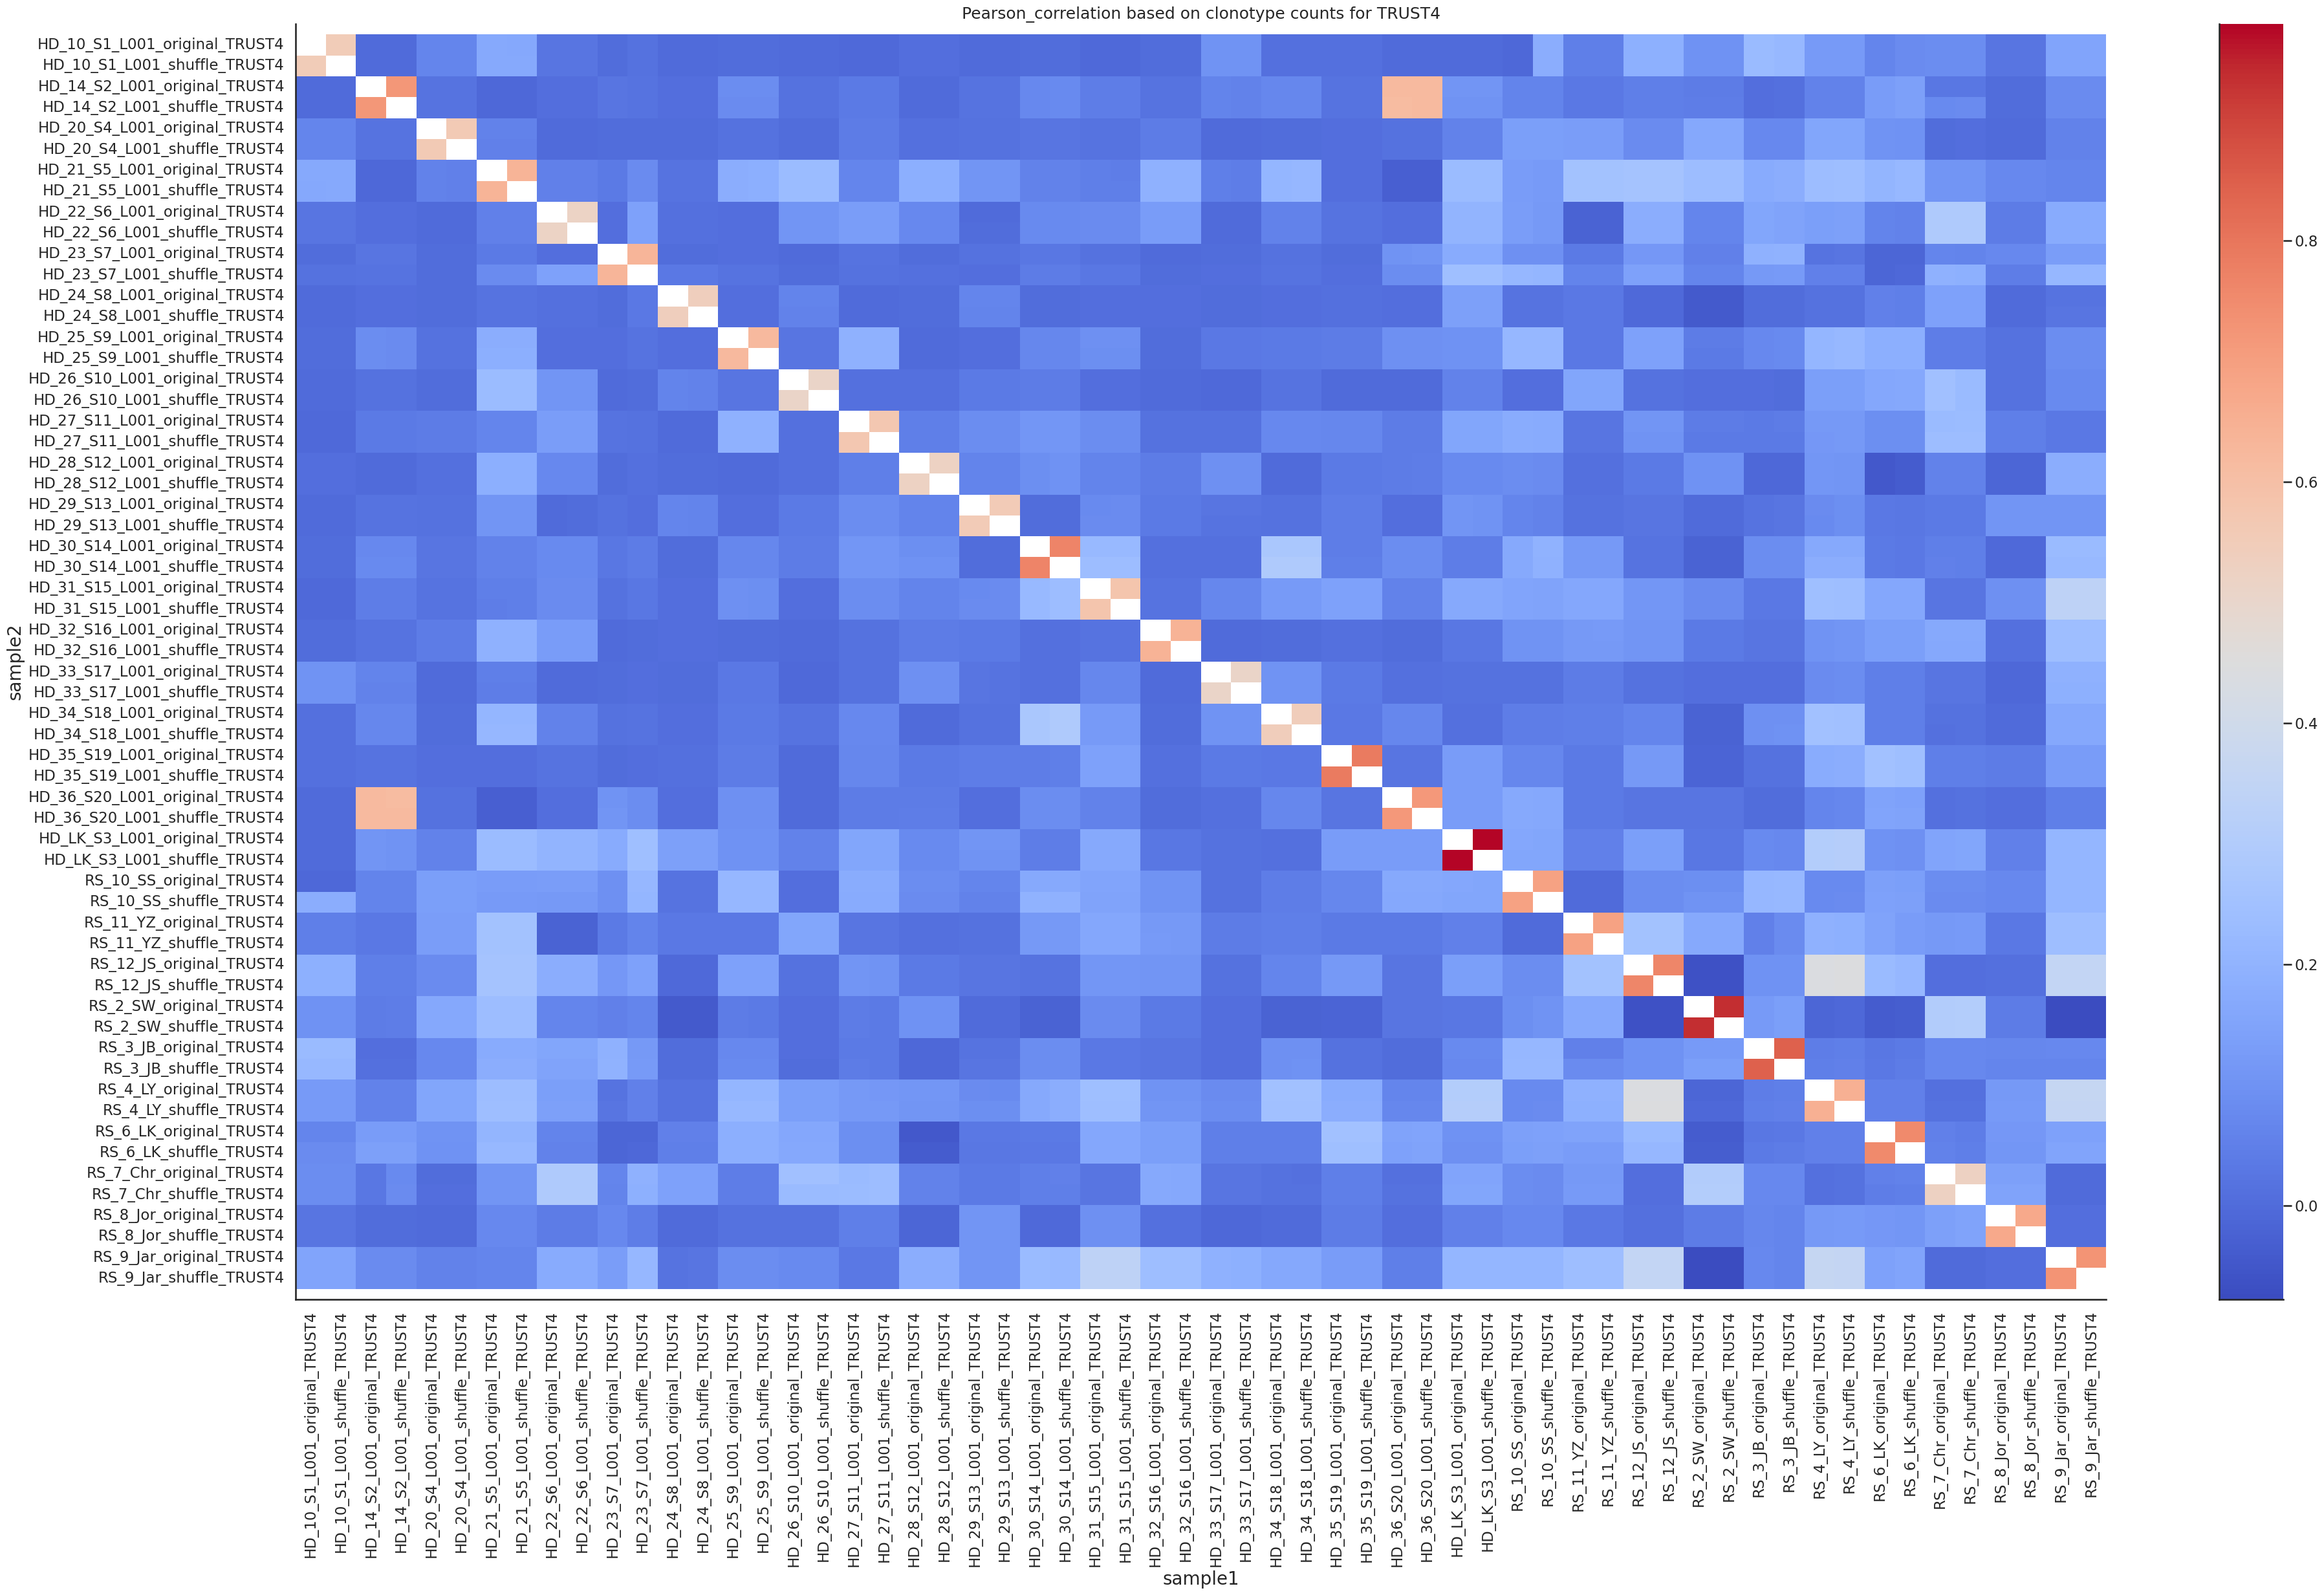

In [16]:
# Set aesthetics
plt.style.use(['ggplot', 'seaborn-v0_8-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# Generate axes
df_pearson_correlation_count['pearson_correlation'] = df_pearson_correlation_count['pearson_correlation'].astype(float)

result = df_pearson_correlation_count.pivot(index='sample_2', columns='sample_1', values='pearson_correlation')

ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample1', fontsize=20)
ax.set_ylabel('sample2', fontsize=20)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('Pearson_correlation based on clonotype counts for TRUST4')
plt.tight_layout()
plt.savefig("/scratch1/pjaiswal/figures/Pearson correlation clonotype counts_TRUST4_inhouse.png", bbox_inches="tight")
sns.despine()
plt.show()

Overlap analysis 6.2.1 - Pearson correlation based on clonotype frequency (result table)

In [17]:
columns = ['sample_1', 'sample_2', 'pearson_correlation']
df_pearson_correlation_freq = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        pearson_correlation_freq = df_overlap['freq_1'].corr(df_overlap['freq_2'])

        data.append({'sample_1': sample1, 'sample_2': sample2,'pearson_correlation': pearson_correlation_freq})
        data.append({'sample_1': sample2, 'sample_2': sample1,'pearson_correlation': pearson_correlation_freq})

    df_data = pd.DataFrame(data)
    df_pearson_correlation_freq = pd.concat(
        [df_pearson_correlation_freq, df_data], copy=False, ignore_index=True)

Overlap analysis 6.2.2 - Pearson correlation based on clonotype frequency (heatmap)

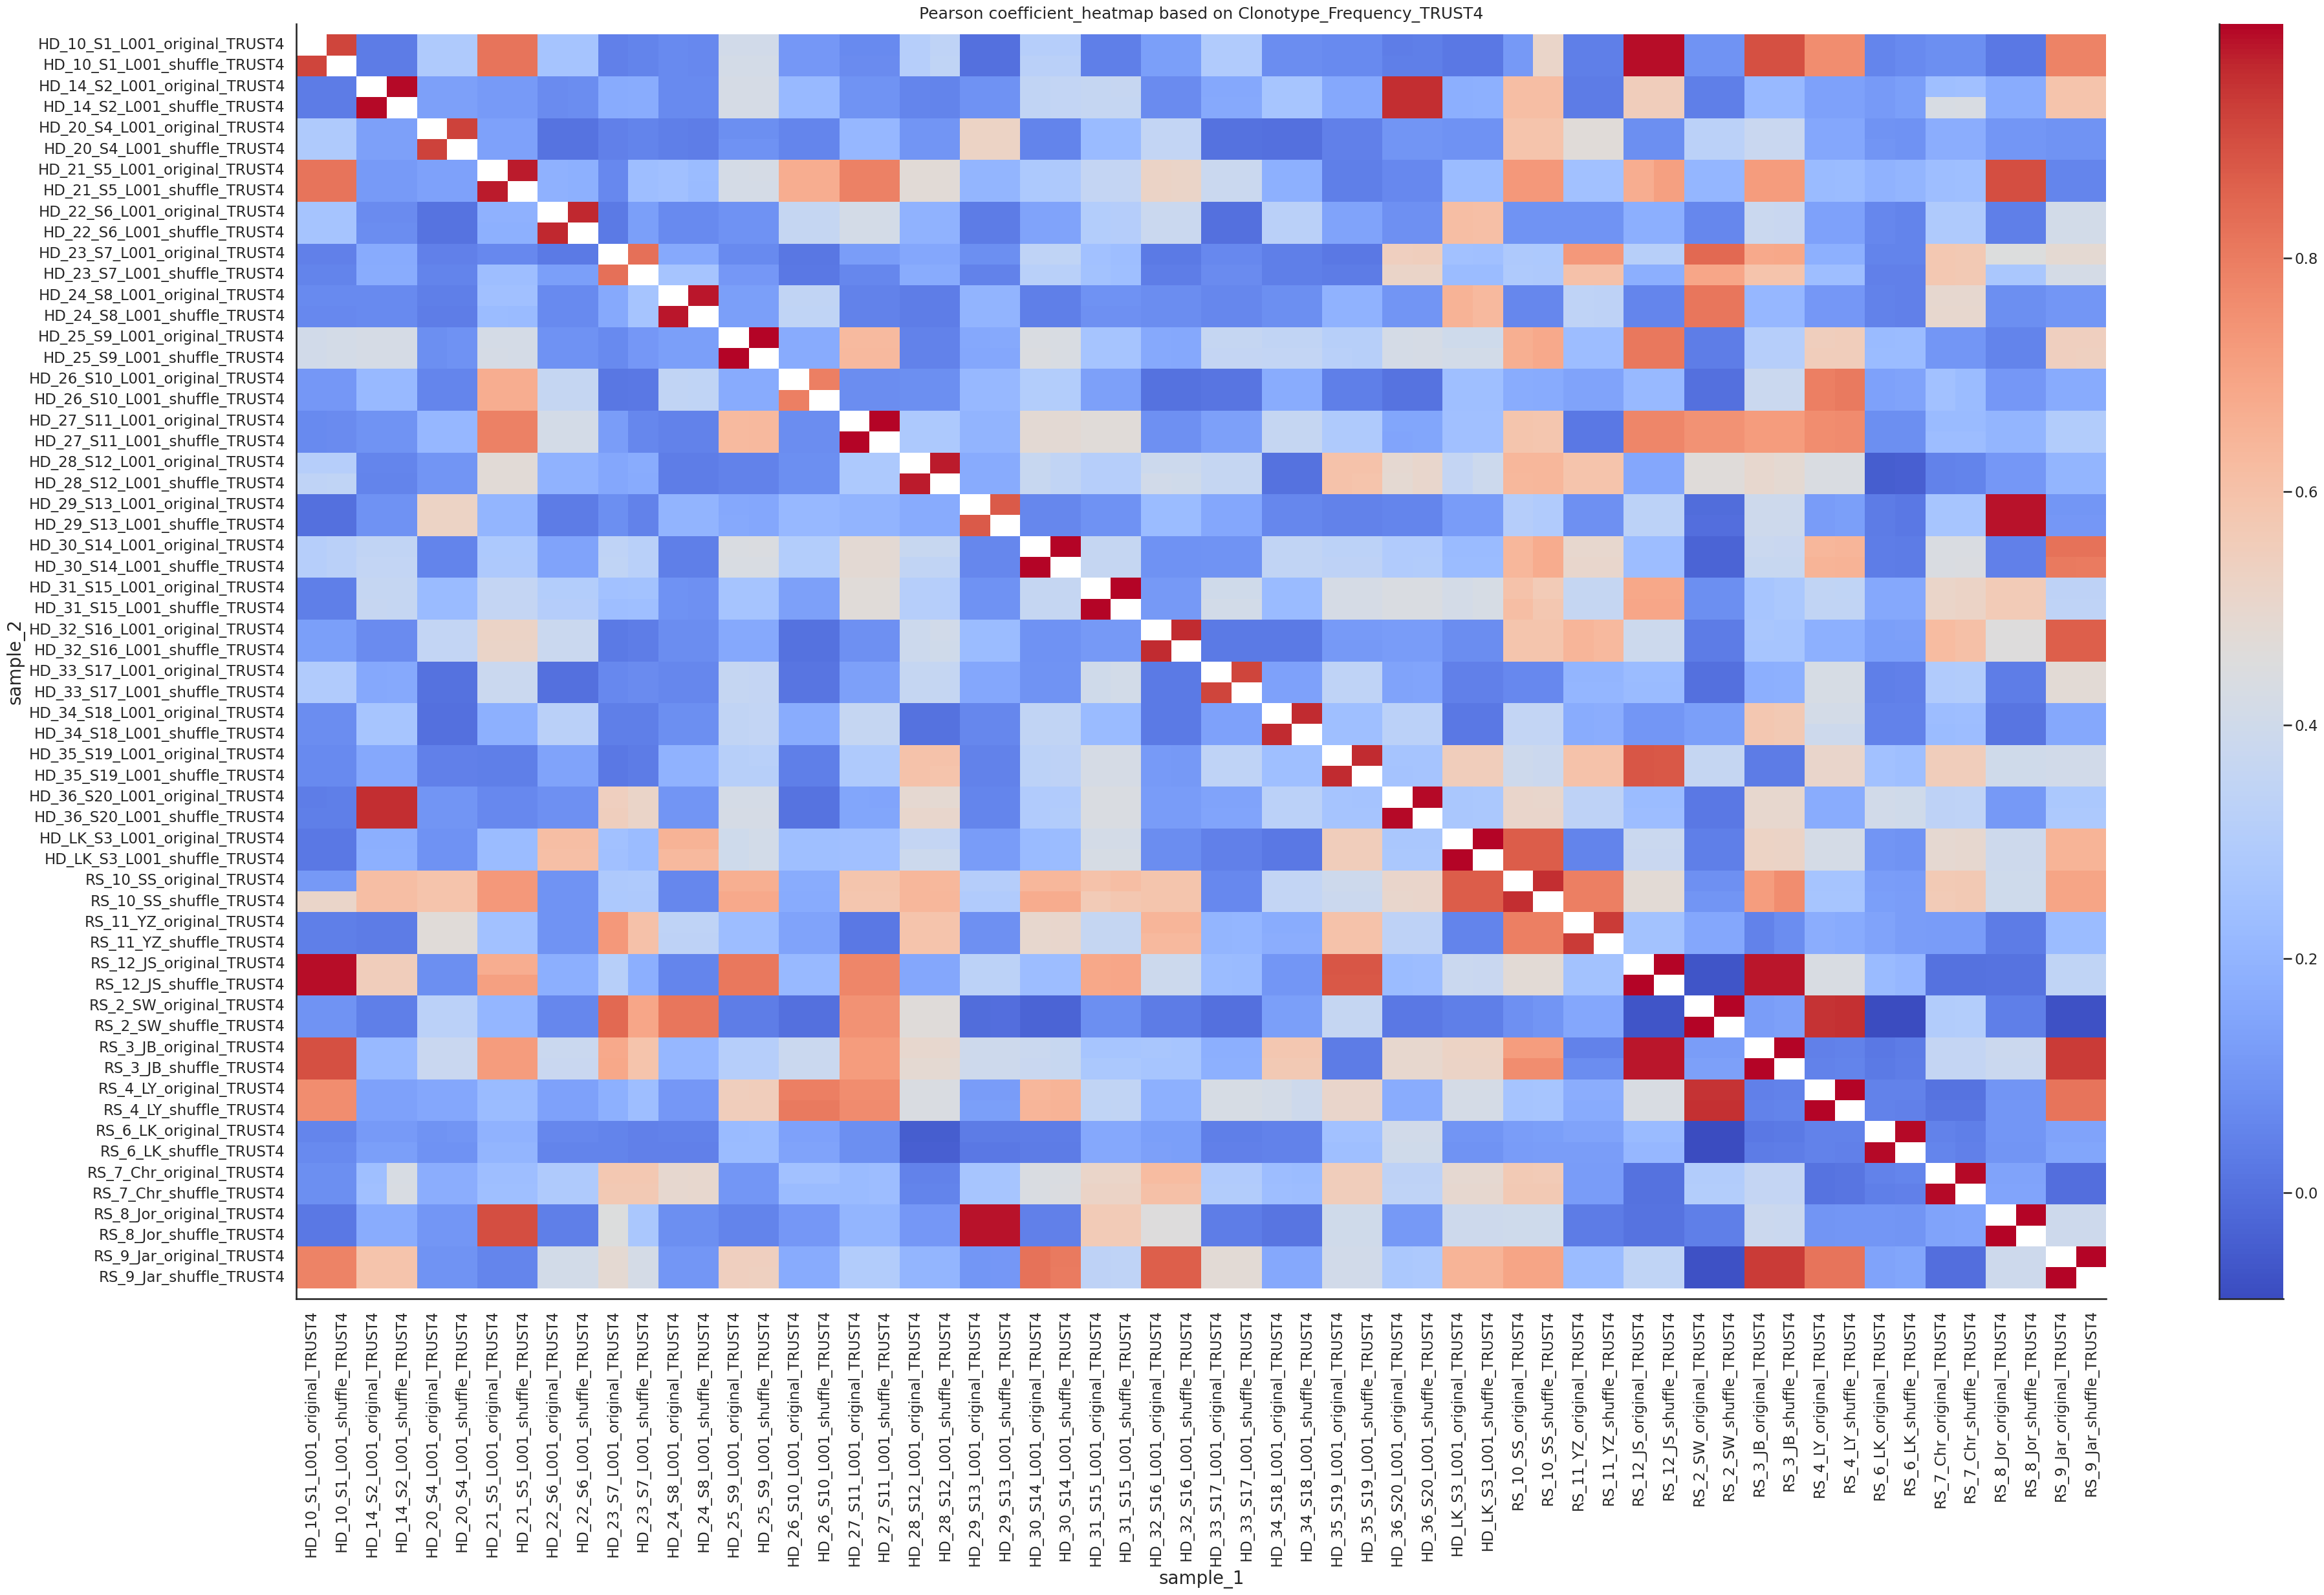

In [18]:
# Set aesthetics
plt.style.use(['ggplot', 'seaborn-v0_8-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# Generate axes
df_pearson_correlation_freq['pearson_correlation'] = df_pearson_correlation_freq['pearson_correlation'].astype(float)

result = df_pearson_correlation_freq.pivot(index='sample_2', columns='sample_1', values='pearson_correlation')

ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=20)
ax.set_ylabel('sample_2', fontsize=20)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('Pearson coefficient_heatmap based on Clonotype_Frequency_TRUST4')
plt.tight_layout()
plt.savefig("/scratch1/pjaiswal/figures/Pearson coefficient_heatmap based on Clonotype_Frequency_TRUST4.png", bbox_inches='tight')
sns.despine()
plt.show()

Overlap analysis 7.1 - Relative overlap diversity (result table)

In [23]:
columns = ['sample_1', 'sample_2', 'relative_overlap_diversity']
df_relative_overlap_diversity = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        relative_overlap_diversity = df_overlap.shape[0] / (
            df_sample1.shape[0] * df_sample2.shape[0])

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'relative_overlap_diversity': relative_overlap_diversity})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'relative_overlap_diversity': relative_overlap_diversity})

    df_data = pd.DataFrame(data)
    df_relative_overlap_diversity = pd.concat([df_relative_overlap_diversity, df_data], copy=False, ignore_index=True)

/tmp/SLURM_23695538/ipykernel_61297/990860747.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_relative_overlap_diversity = pd.concat([df_relative_overlap_diversity, df_data], copy=False, ignore_index=True)


Overlap analysis 7.2 - Relative overlap diversity (heatmap)

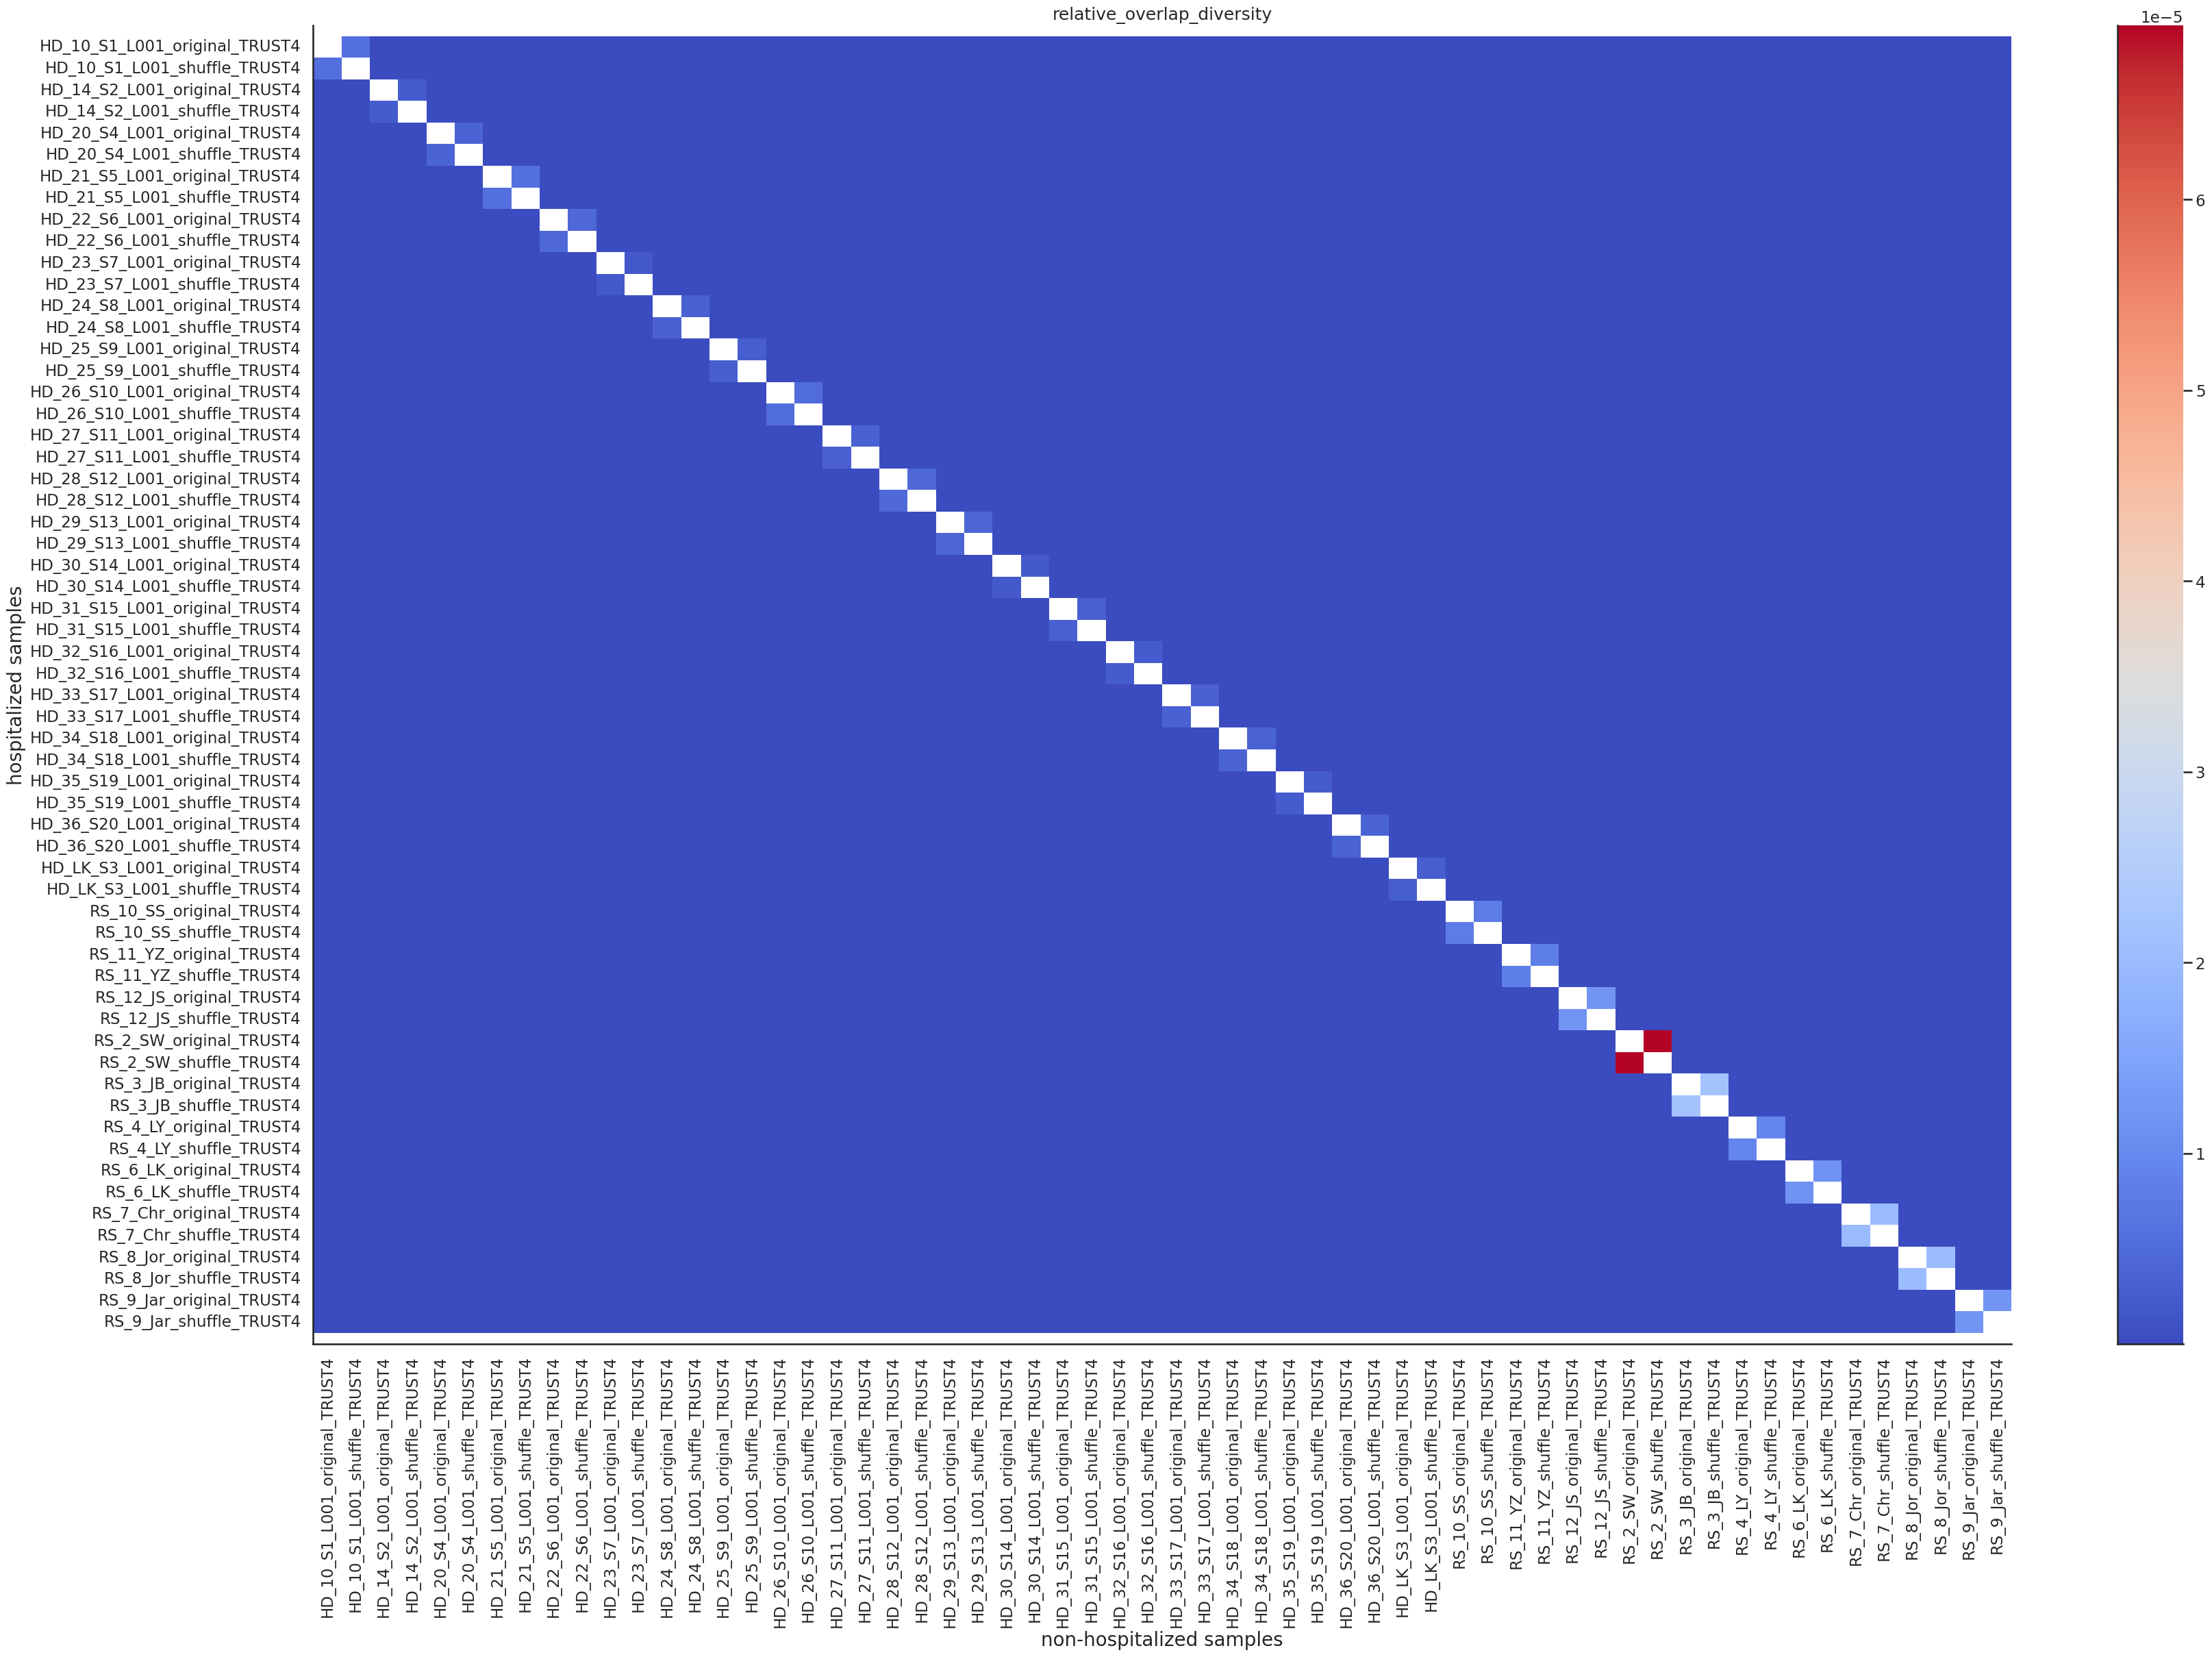

In [24]:
# Set aesthetics
plt.style.use(['ggplot', 'seaborn-v0_8-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# Generate axes
df_relative_overlap_diversity['relative_overlap_diversity'] = df_relative_overlap_diversity['relative_overlap_diversity'].astype(
    float)

result = df_relative_overlap_diversity.pivot(index='sample_2', columns='sample_1', values='relative_overlap_diversity')

ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('non-hospitalized samples', fontsize=20)
ax.set_ylabel('hospitalized samples', fontsize=20)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('relative_overlap_diversity')
sns.despine()
plt.show()

Overlap analysis 8.1 - Geometric mean of relative overlap frequencies (result table)

In [25]:
columns = ['sample_1', 'sample_2',
           'geometric_mean_of_relative_overlap_frequencies']

df_geometric_mean_of_relative_overlap_frequencies = pd.DataFrame(
    columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        result = (df_overlap['freq_1'].sum() * df_overlap['freq_2'].sum())**0.5

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'geometric_mean_of_relative_overlap_frequencies': result})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'geometric_mean_of_relative_overlap_frequencies': result})

    df_data = pd.DataFrame(data)
    df_geometric_mean_of_relative_overlap_frequencies = pd.concat(
        [df_geometric_mean_of_relative_overlap_frequencies, df_data], copy=False, ignore_index=True)

/tmp/SLURM_23695538/ipykernel_61297/1177382919.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_geometric_mean_of_relative_overlap_frequencies = pd.concat(


Overlap analysis 8.2 - Geometric mean of relative overlap frequencies (heatmap)

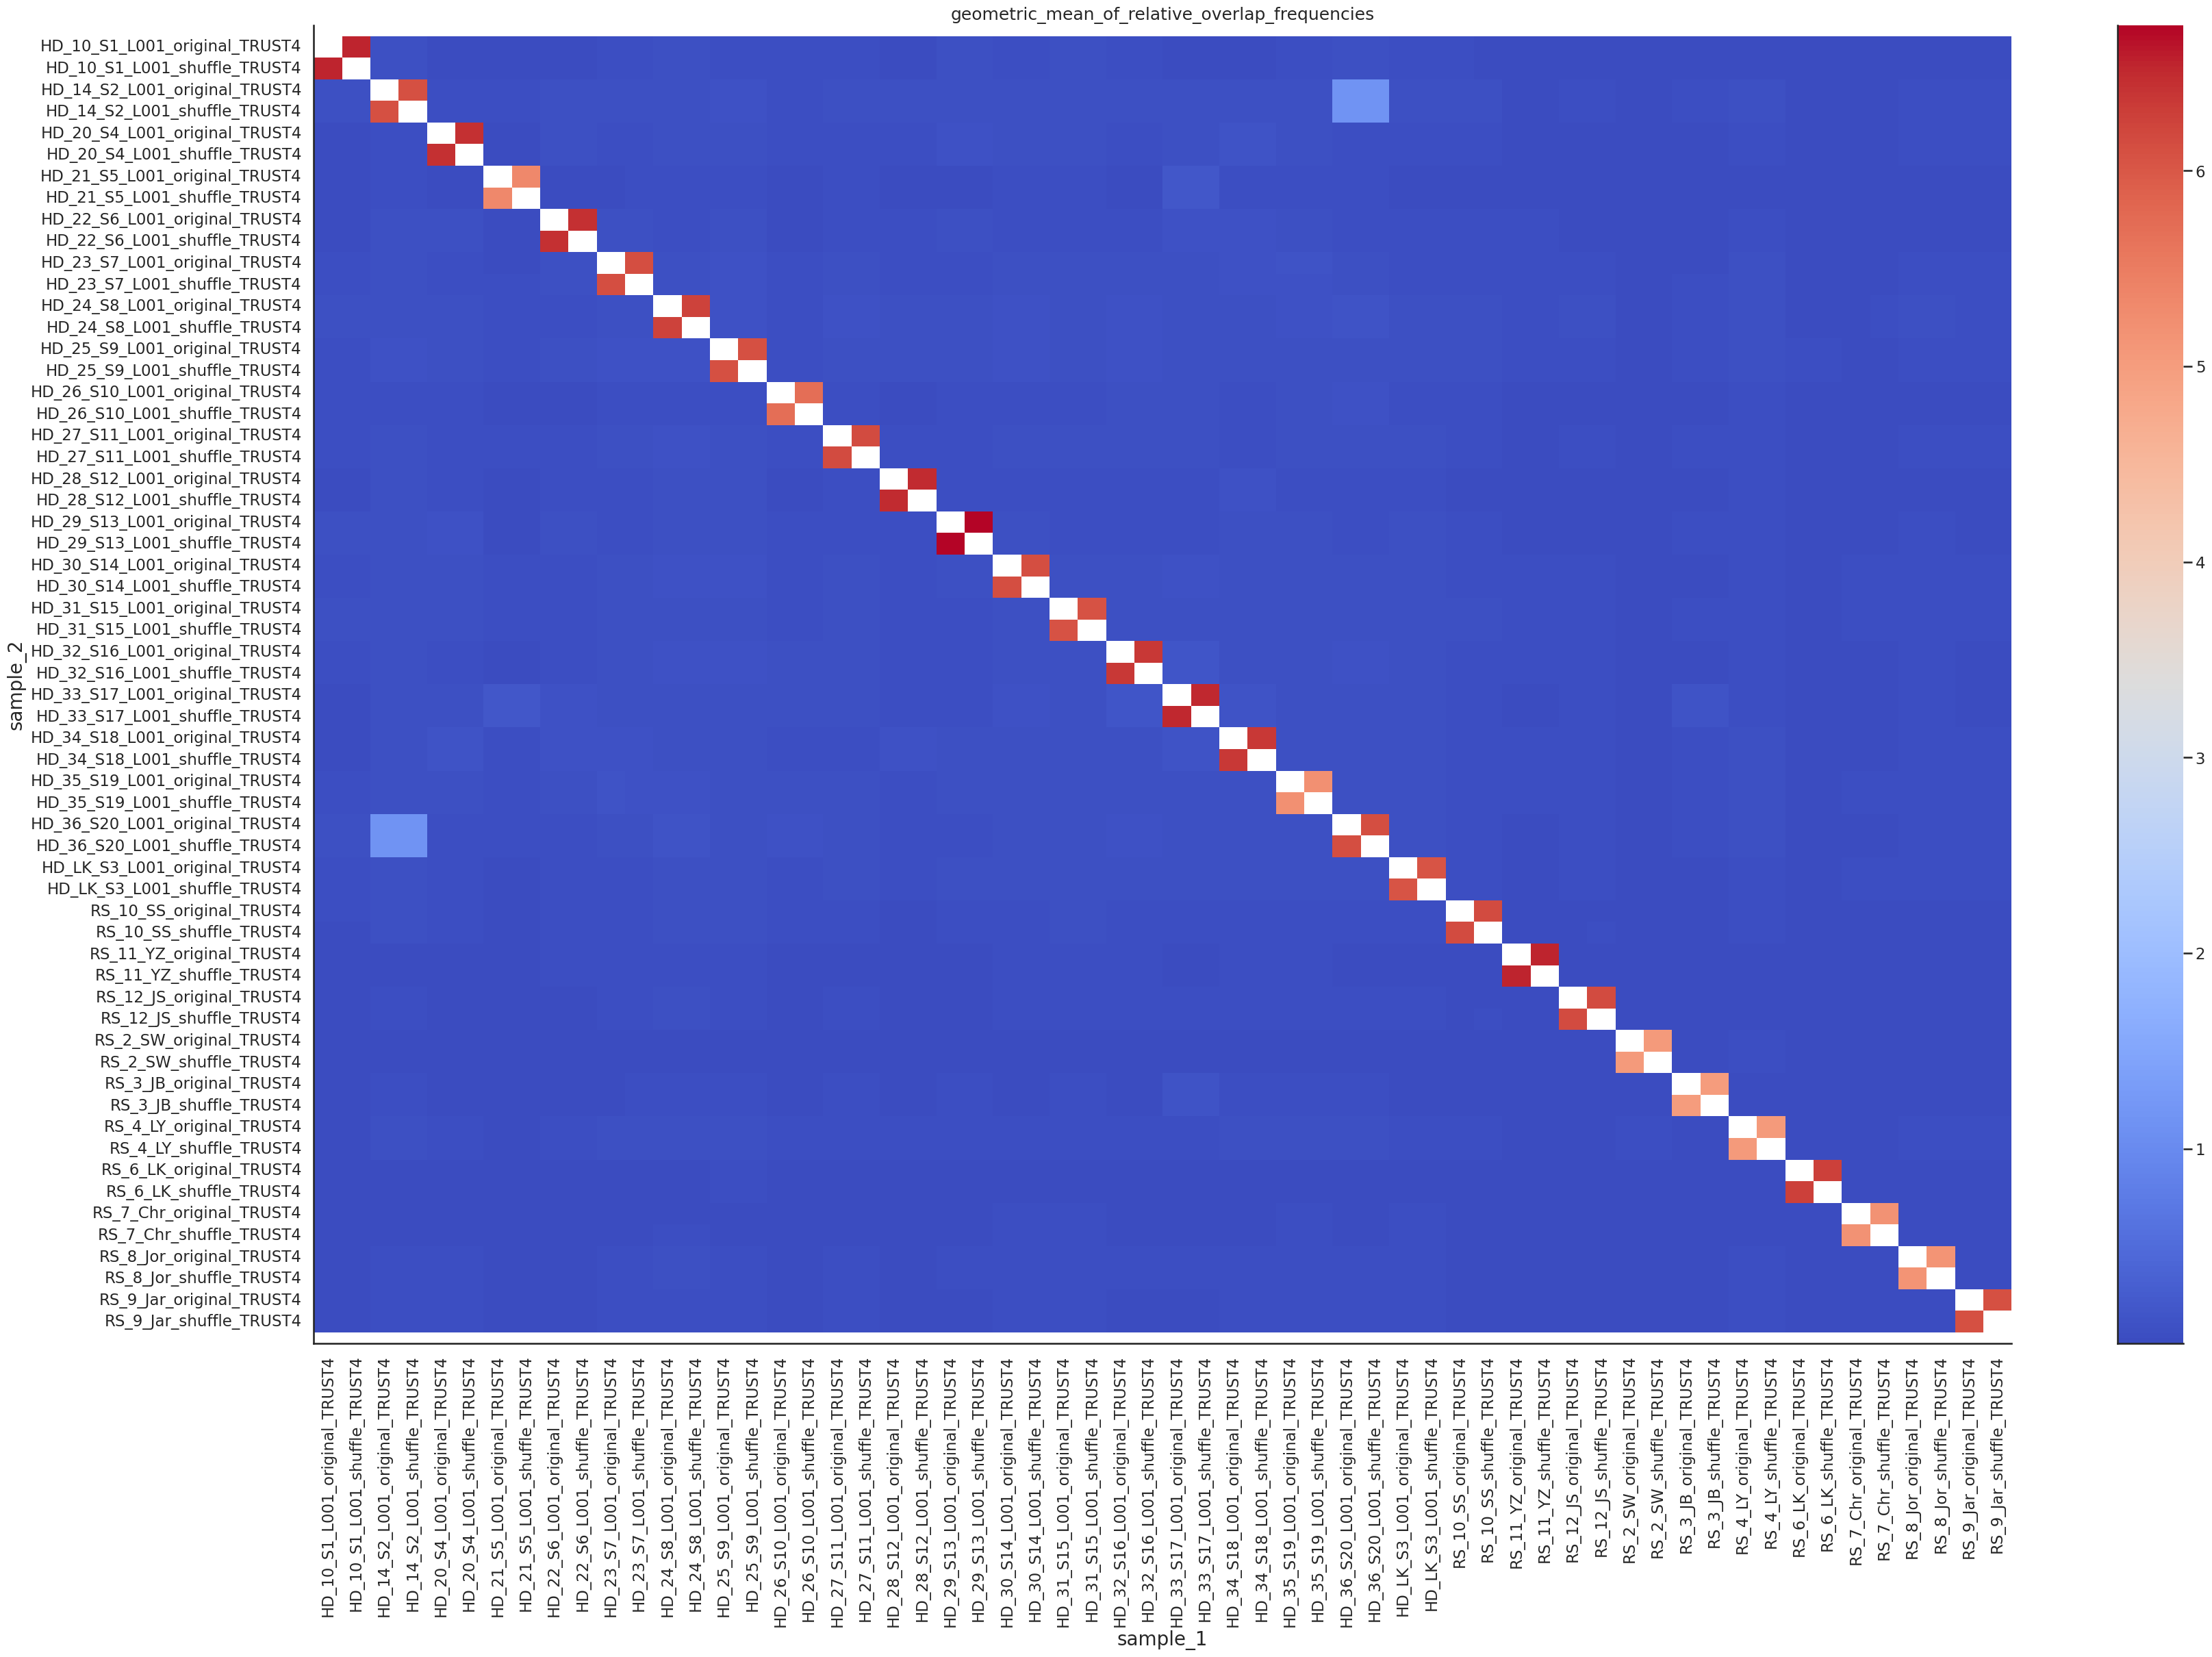

In [26]:
# Set aesthetics
plt.style.use(['ggplot', 'seaborn-v0_8-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# Generate axes
df_geometric_mean_of_relative_overlap_frequencies['geometric_mean_of_relative_overlap_frequencies'] = df_geometric_mean_of_relative_overlap_frequencies[
    'geometric_mean_of_relative_overlap_frequencies'].astype(float)

result = df_geometric_mean_of_relative_overlap_frequencies.pivot(
    index='sample_2', columns='sample_1', values='geometric_mean_of_relative_overlap_frequencies')

ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=20)
ax.set_ylabel('sample_2', fontsize=20)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('geometric_mean_of_relative_overlap_frequencies')
sns.despine()
plt.show()

Overlap analysis 9.1 - Сlonotype-wise sum of geometric mean frequencies (result table)

In [36]:
columns = ['sample_1', 'sample_2',
           'clonotype_wise_sum_of_geometric_mean_frequencies']

df_clonotype_wise_sum_of_geometric_mean_frequencies = pd.DataFrame(columns=columns)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]

        df_overlap = df_overlaps[f'{sample1}:{sample2}']

        result = ((df_overlap['freq_1']*df_overlap['freq_2'])**0.5).sum()

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'clonotype_wise_sum_of_geometric_mean_frequencies': result})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'clonotype_wise_sum_of_geometric_mean_frequencies': result})

    df_data = pd.DataFrame(data)
    df_clonotype_wise_sum_of_geometric_mean_frequencies = pd.concat(
        [df_clonotype_wise_sum_of_geometric_mean_frequencies, df_data], copy=False, ignore_index=True)

Overlap analysis 9.2 - Clonotype-wise sum of geometric mean frequencies (heatmap)

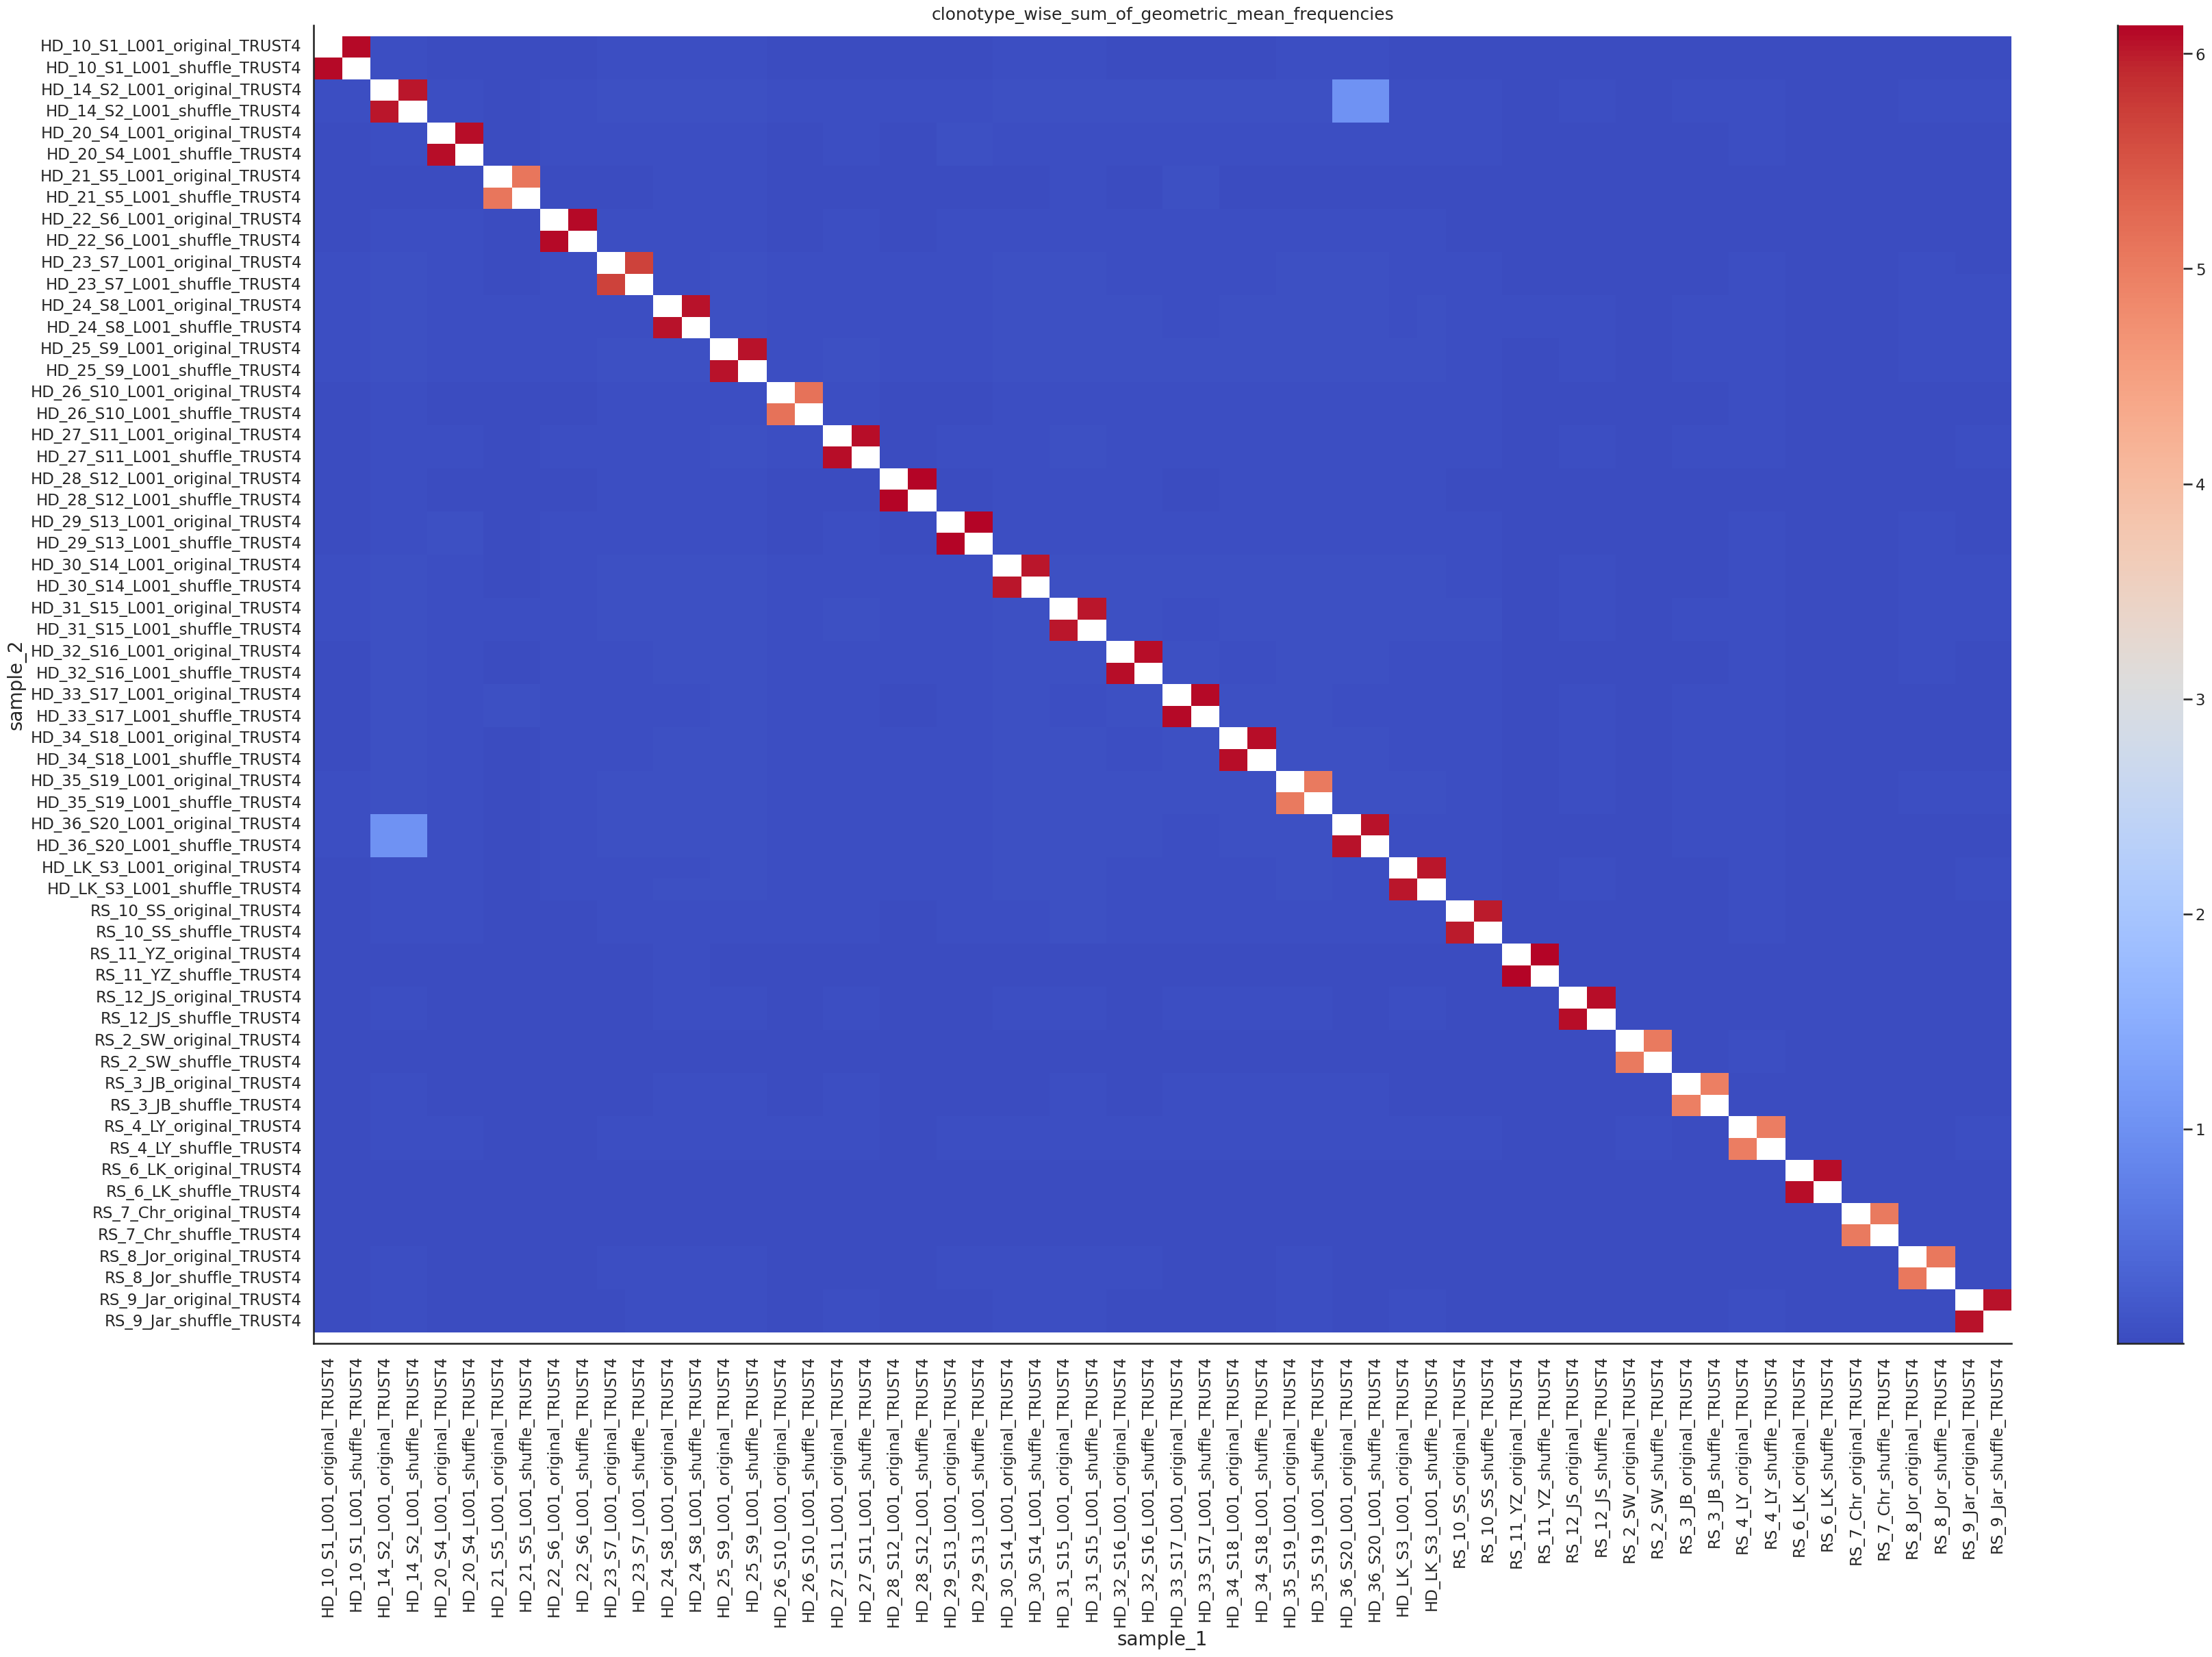

In [37]:
# Set aesthetics
plt.style.use(['ggplot', 'seaborn-v0_8-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# Generate axes
df_clonotype_wise_sum_of_geometric_mean_frequencies['clonotype_wise_sum_of_geometric_mean_frequencies'] = df_clonotype_wise_sum_of_geometric_mean_frequencies[
    'clonotype_wise_sum_of_geometric_mean_frequencies'].astype(float)

result = df_clonotype_wise_sum_of_geometric_mean_frequencies.pivot(
    index='sample_2', columns='sample_1', values='clonotype_wise_sum_of_geometric_mean_frequencies')

ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=20)
ax.set_ylabel('sample_2', fontsize=20)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('clonotype_wise_sum_of_geometric_mean_frequencies')
sns.despine()
plt.show()

Overlap analysis 10.1 - Jensen-Shannon divergence of variable segment usage distributions (result table)

In [19]:
columns = ['sample_1', 'sample_2', 'jensen_shannon_divergence']
df_jensen_shannon_divergence = pd.DataFrame(columns=columns)

def kl_divergence(p, q):
    return -np.sum(p * np.log2(q / p))

def js_divergence(p, q):
    m = (1 / 2) * (p + q)
    return (1 / 2) * kl_divergence(p, m) + (1 / 2) * kl_divergence(q, m)

for i in range(0, sample_names_size):
    sample1 = sample_names[i]
    df_sample1 = samples[sample1]

    data = []

    for j in range(i + 1, sample_names_size):
        sample2 = sample_names[j]
        df_sample2 = samples[sample2]

        df_sample1_v = df_sample1.groupby(['v'], as_index=False)[
            'freq'].agg({'sumfreq_1': 'sum'})
        df_sample2_v = df_sample2.groupby(['v'], as_index=False)[
            'freq'].agg({'sumfreq_2': 'sum'})

        df_JSD_combine = pd.merge(df_sample1_v, df_sample2_v, on=['v'])

        JSD_sample1 = df_JSD_combine[['sumfreq_1']].to_numpy()
        JSD_sample2 = df_JSD_combine[['sumfreq_2']].to_numpy()

        result = js_divergence(JSD_sample1, JSD_sample2)

        data.append({'sample_1': sample1, 'sample_2': sample2,
                    'jensen_shannon_divergence': result})
        data.append({'sample_1': sample2, 'sample_2': sample1,
                    'jensen_shannon_divergence': result})

    df_data = pd.DataFrame(data)
    df_jensen_shannon_divergence = pd.concat(
        [df_jensen_shannon_divergence, df_data], copy=False, ignore_index=True)

Overlap analysis 10.2 - Jensen-Shannon divergence of variable segment usage distributions (heatmap)

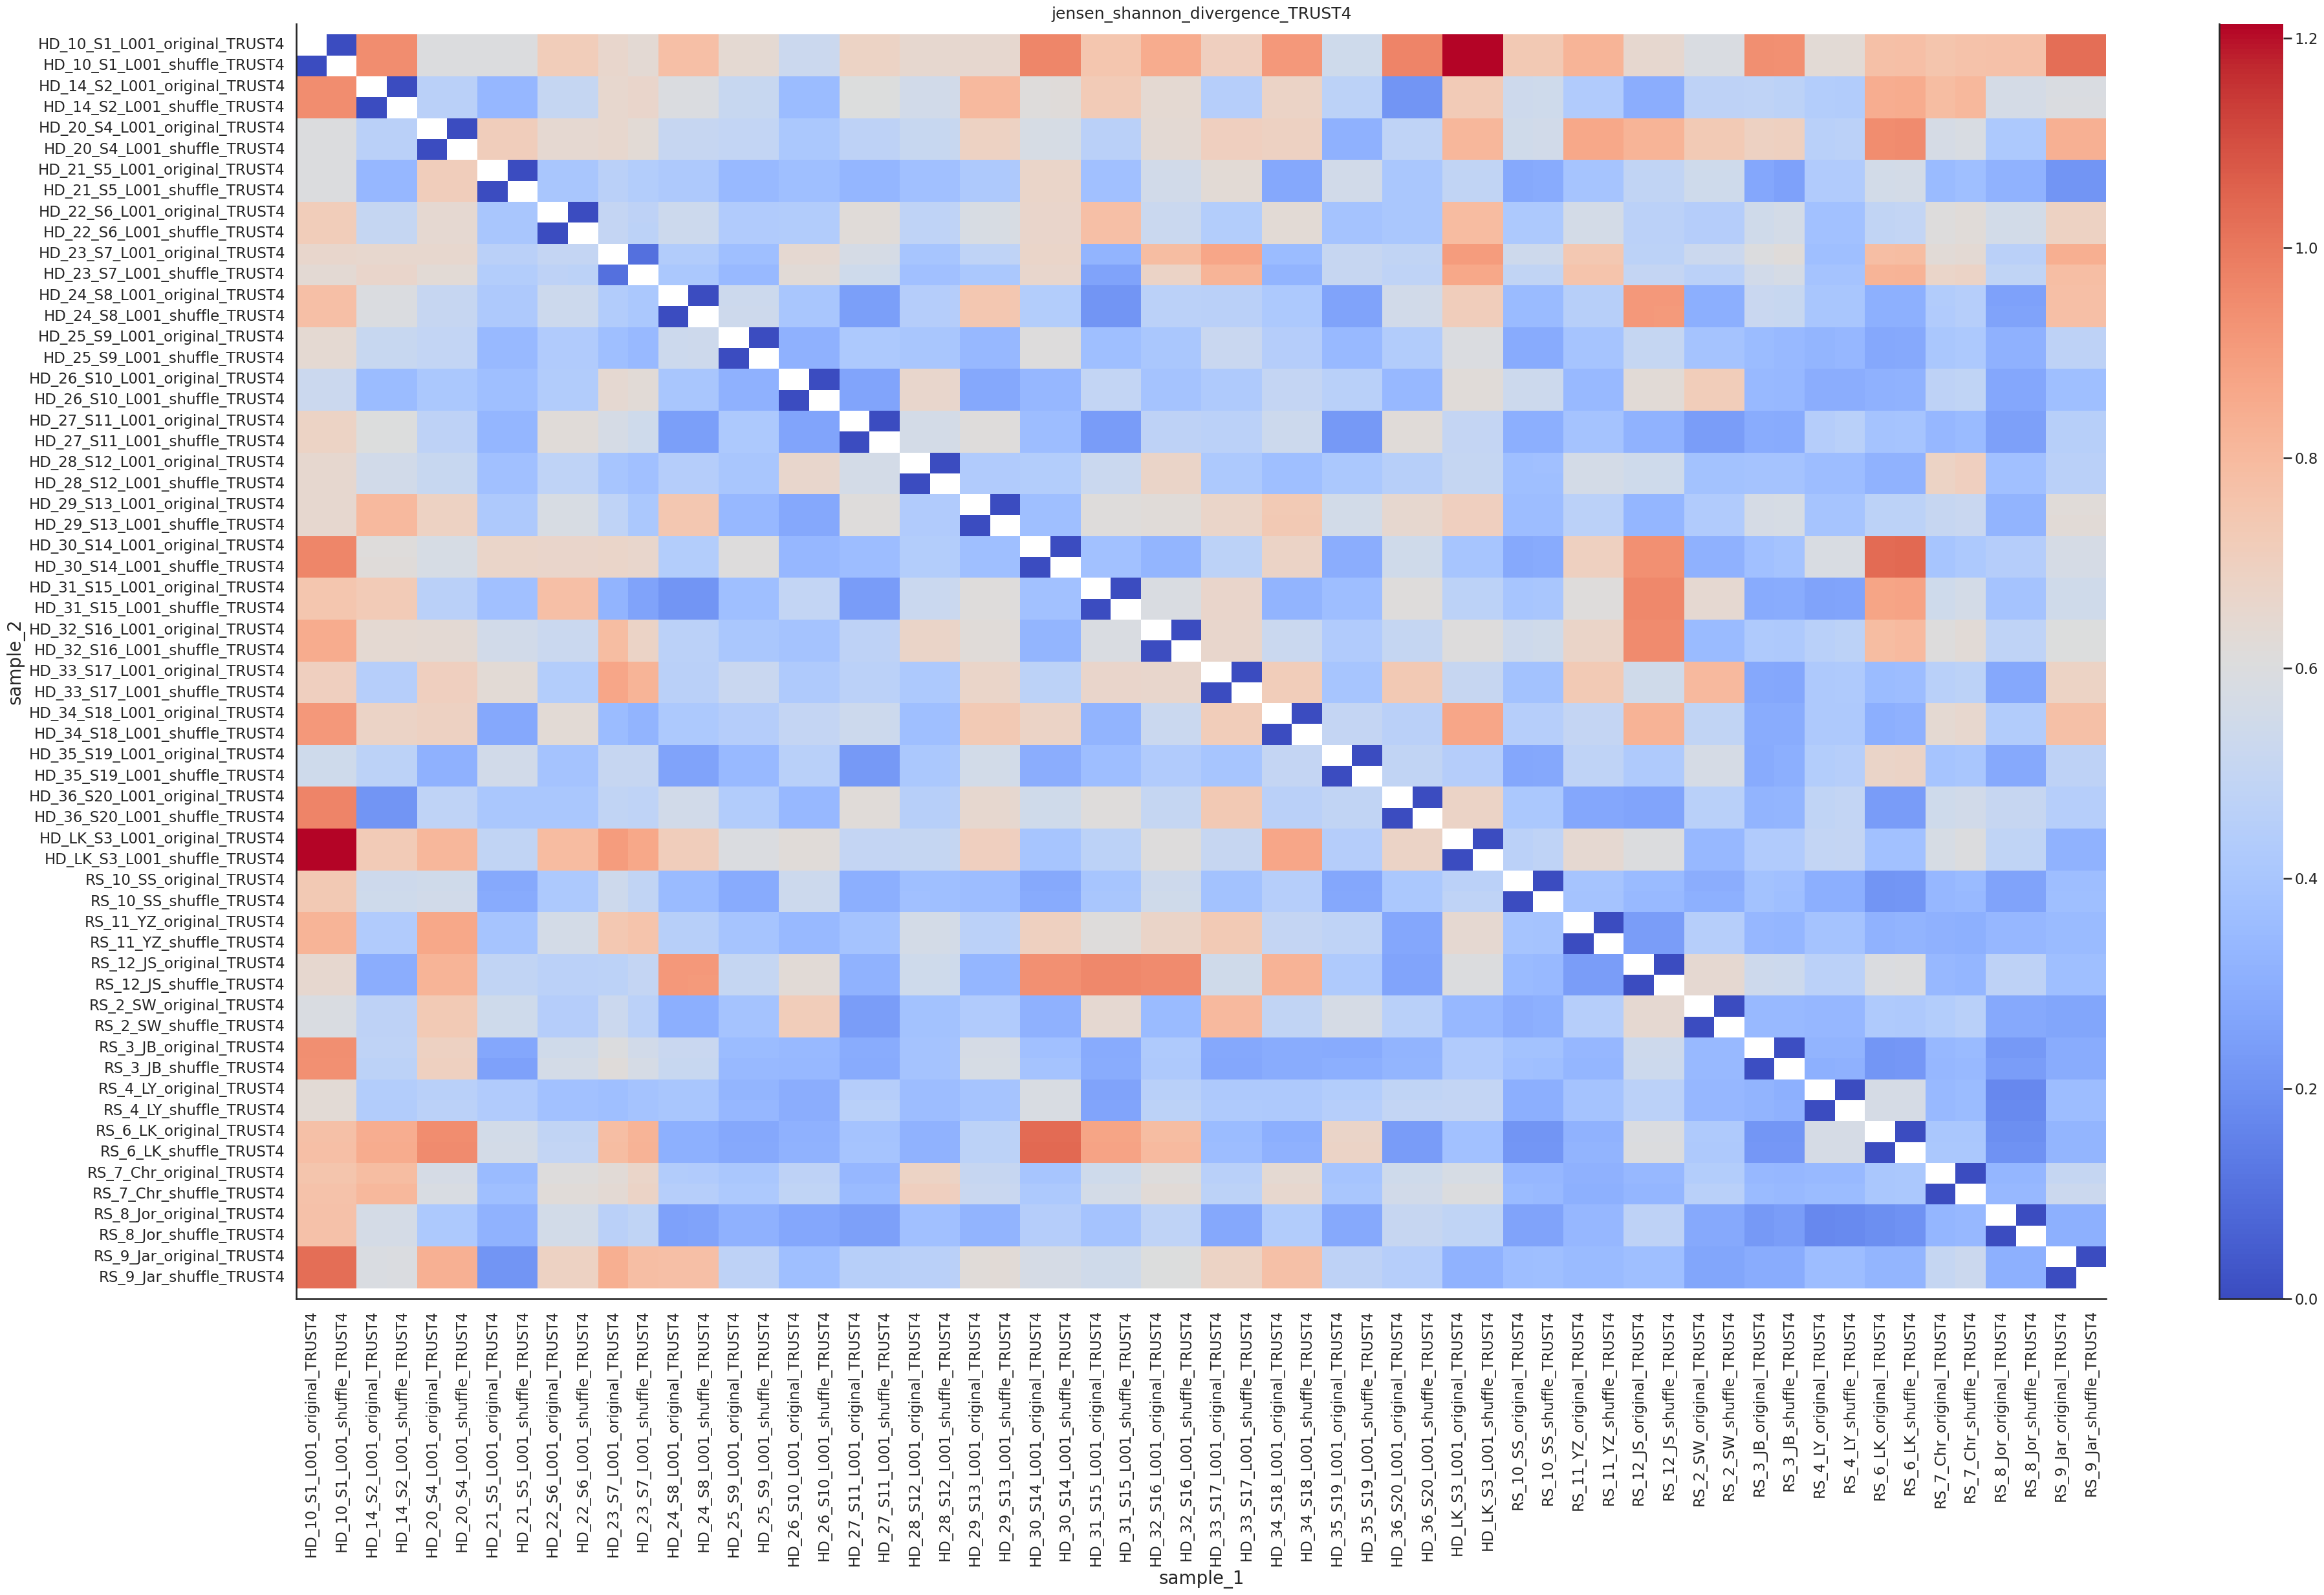

In [32]:
# Set aesthetics
plt.style.use(['ggplot', 'seaborn-v0_8-white'])
plt.figure(figsize=(40, 25))
sns.set_style("white")
sns.set_context("talk")

# Generate axes
df_jensen_shannon_divergence['jensen_shannon_divergence'] = df_jensen_shannon_divergence['jensen_shannon_divergence'].astype(
    float)

result = df_jensen_shannon_divergence.pivot(index='sample_2', columns='sample_1', values='jensen_shannon_divergence')

ax = sns.heatmap(result, cmap='coolwarm')
ax.set_xlabel('sample_1', fontsize=20)
ax.set_ylabel('sample_2', fontsize=20)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('jensen_shannon_divergence_TRUST4')
plt.tight_layout()
plt.savefig("/scratch1/pjaiswal/ipynb_notebooks/Figures/Jensen_Shannon_TRUST4.pdf")
sns.despine()
plt.show()